In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 10 13:53:00 2017

@author: ncaplar@princeton.edu

"""
%connect_info

{
  "stdin_port": 59367, 
  "ip": "127.0.0.1", 
  "control_port": 59368, 
  "hb_port": 59369, 
  "signature_scheme": "hmac-sha256", 
  "key": "65875d59-0c14a927fed91b8625fbdb34", 
  "kernel_name": "", 
  "shell_port": 59365, 
  "transport": "tcp", 
  "iopub_port": 59366
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-4d6fd96f-e5aa-4e45-965f-9e5a7a8fa21f.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [3]:
#import statments
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=12000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
import time



import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

#np.seterr(divide='ignore', invalid='ignore')

# Modelling slit

In [2]:
#import statments
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=12000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
import time



import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

#np.seterr(divide='ignore', invalid='ignore')

In [5]:
#__all__ = ['PupilFactory', 'Pupil']

class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale

class PupilFactory(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @params others
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.illumminatedFrac=illumminatedFrac
        self.pupilScale = pupilSize/npix
        self.slitFrac=slitFrac
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        

class PFSPupilFactory(PupilFactory):
    """!Pupil obscuration function factory for PFS 
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = (self.pupilSize/2)*self.illumminatedFrac

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        slitFrac = self.slitFrac 
        subaruSlit = slitFrac*subaruRadius
        # meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 
        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius


        
        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 2.62 / 1000 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98


        hscPlateScale = 380  
        thetaX = point.getX() * hscPlateScale 
        thetaY = point.getY() * hscPlateScale 

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        
        #No vignetting for the spectroscope 
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
            
        self._cutRay(pupil, (2,0), Angle(-np.pi),subaruSlit)    
        return pupil

In [6]:
### ZernikeFitter
class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    The centroid parameters are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,
                 jacobian=None,nonUniformEffect=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds (this is spectroscop)
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        """
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        # Note that this is a spectroscop and not an normal optical telescope,
        #so this is not real physical quantity
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        # Again, wavelength - this is a spectroscop
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        if nonUniformEffect is None:
            nonUniformEffect==False
        
        self.kwargs = kwargs
    
    def initParams(self, zmax=4, z4Init=None, centroidInit=None,hscFracInit=None,strutFracInit=None,
                   focalPlanePositionInit=None,diam_sicInit=None,fiber_rInit=None,flux_multInit=None,
                  npixInit=None,side_of_focusInit=None,slitFracInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves.
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscuraded by the camera ()
        @param strutFracInit        Fraction of the pupil obscuraded by the single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Size of the telescope in meters
        @param fiber_rInit          Factor that determines the size of the input fiber
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if centroidInit is None:
            params.add('dx', 0.0)
            params.add('dy', 0.0)
        else:
            params.add('dx', centroidInit[0])
            params.add('dy', centroidInit[1])   
            
        if hscFracInit is None:
            params.add('hscFrac', 0)
        else:
            params.add('hscFrac', hscFracInit)        

        if strutFracInit is None:
            params.add('strutFrac', 0)
        else:
            params.add('strutFrac', strutFracInit)             

        if focalPlanePositionInit is None:
            params.add('dxFocal', 0.0) 
            params.add('dyFocal', 0.0) 
        else:
            params.add('dxFocal', focalPlanePositionInit[0]) 
            params.add('dyFocal', focalPlanePositionInit[1]) 
            
        if diam_sicInit is None:
            params.add('diam_sic', 3.3)
        else:
            params.add('diam_sic', diam_sicInit)   
            
        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
            
        if flux_multInit is None:
            params.add('flux_mult', 1)
        else:
            params.add('flux_mult', flux_multInit)    
        
        if npixInit is None:
            params.add('npix', 512)
        else:
            params.add('npix', npixInit)    
            
        if side_of_focusInit is None:
            params.add('side_of_focus', 1)
        else:
            params.add('side_of_focus', side_of_focusInit)    
            
        if slitFracInit is None:
            params.add('slitFrac', 0)
        else:
            params.add('slitFrac', slitFracInit)     
            
        
        params.add('illumminatedFrac',0.96)        
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        Pupil_Image=PFSPupilFactory(params['diam_sic'.format(i)],params['npix'.format(i)],
                                    params['side_of_focus'.format(i)]*np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],
                                  params['illumminatedFrac'.format(i)],params['slitFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=10240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params,pad_factor=1.5)

    def constructModelImage_PFS(self,params=None,shape=None,pixelScale=None,jacobian=None,nonUniformEffect=False):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)


        #This creates opticalpsf
        if nonUniformEffect==False:
            # 1 component
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
                
                
            optPsf=self._getOptPsf(v)
            optPsf = optPsf.shift(v['dx'], v['dy'])
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*v['fiber_r'])
            final = galsim.Convolve([gal, optPsf])
            modelImg = final.drawImage(
            nx = shape[0],
            ny = shape[1],
            wcs = wcs)
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg.array
        else:
            # 3 components
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
            
                        
            v['illumminatedFrac']=0.96
            optPsf1=self._getOptPsf(v)
            optPsf1 = optPsf1.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=0.986
            optPsf2=self._getOptPsf(v)
            optPsf2 = optPsf2.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=1
            optPsf3=self._getOptPsf(v)
            optPsf3 = optPsf3.shift(v['dx'], v['dy'])
            
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal1 = galsim.TopHat(flux=0.32, radius=(3/8)*(3/2)*v['fiber_r'])
            gal2 = galsim.TopHat(flux=0.334, radius=(3/8)*(3/2)*v['fiber_r'])
            gal3 = galsim.TopHat(flux=0.346, radius=(3/8)*(3/2)*v['fiber_r'])
            
            final1 = galsim.Convolve([gal1, optPsf1])
            final2 = galsim.Convolve([gal2, optPsf2])
            final3 = galsim.Convolve([gal3, optPsf3])
            
            modelImg1 = final1.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg2 = final2.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg3 = final3.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            
            modelImg=np.add(np.add(modelImg1.array,modelImg2.array),modelImg3.array)
            
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg

    
    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
       
# I think I do not need anything below
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

In [110]:
def create_low_median_values_and_errors(flatchain,likeflatchain):
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
       
    manual_medians=np.apply_along_axis(np.median, 0, flatchain_low)
    manual_medians_std=np.apply_along_axis(np.std, 0, flatchain_low)
    return manual_medians,manual_medians_std

In [116]:
date='Nov09'
run=str(7310)
single_number=str(131)
                
likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                  '/likechain'+date+'_'+run+str(single_number)+'z4.npy')
chichain4=likechain*(-2/(70**2-10))

likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                  '/likechain'+date+'_'+run+str(single_number)+'z11.npy')
chichain11=likechain*(-2/(70**2-17))
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                 '/flatchain'+date+'_'+run+str(single_number)+'z22.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                 '/likeflatchain'+date+'_'+run+str(single_number)+'z22.npy')
likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                 '/likechain'+date+'_'+run+str(single_number)+'z22.npy')
chichain22=likechain*(-2/(70**2-28))


In [120]:
x=flatchain[likeflatchain==np.min(likeflatchain)][0]

In [592]:
median_values_and_errors=create_low_median_values_and_errors(flatchain,likeflatchain)

In [121]:
x

array([ 11.91972556,   0.67103612,  -0.67623843,  -0.04481126,
         0.19607627,  -0.00100437,  -0.07297692,   0.3745512 ,
        -0.04790567,   0.00381218,   0.00768271,  -0.03496982,
        -0.01473703,  -0.02762097,  -0.03404435,  -0.03226845,
         0.0047    ,  -0.01738081,  -0.13499297,  -0.36039406,
         0.21677125,   0.98496784,   0.18144565,  -0.22457575,
        -0.33254334,   1.48069663,   0.91037838])

In [122]:
single_image_analysis=ZernikeFitter_PFS()
single_image_analysis.initParams(zmax=22)
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)  

single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['diam_sic'].set(3.3)  
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['z12'].set(x[8])
single_image_analysis.params['z13'].set(x[9])
single_image_analysis.params['z14'].set(x[10])
single_image_analysis.params['z15'].set(x[11])
single_image_analysis.params['z16'].set(x[12])
single_image_analysis.params['z17'].set(x[13])
single_image_analysis.params['z18'].set(x[14])
single_image_analysis.params['z19'].set(x[15])      
single_image_analysis.params['z20'].set(x[16])
single_image_analysis.params['z21'].set(x[17]) 
single_image_analysis.params['z22'].set(x[18]) 
single_image_analysis.params['dx'].set(x[19])
single_image_analysis.params['dy'].set(x[20])
single_image_analysis.params['hscFrac'].set(x[21])
single_image_analysis.params['strutFrac'].set(x[22])
single_image_analysis.params['dxFocal'].set(x[23])
single_image_analysis.params['dyFocal'].set(x[24])
single_image_analysis.params['fiber_r'].set(x[25])
single_image_analysis.params['flux_mult'].set(x[26])
single_image_analysis.params['npix'].set(756)
single_image_analysis.params['side_of_focus'].set(1)
single_image_analysis.params['diam_sic'].set(3.3) 
single_image_analysis.params['slitFrac'].set(0.1)
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)  

In [123]:
Pupil_data=PFSPupilFactory(single_image_analysis.params['diam_sic'].value,
                           single_image_analysis.params['npix'],
                           single_image_analysis.params['side_of_focus']*np.pi/2,
                           single_image_analysis.params['hscFrac'].value,
                           single_image_analysis.params['strutFrac'].value,0.96,
                           single_image_analysis.params['slitFrac'].value)
point=Point2D(single_image_analysis.params['dxFocal'].value,
          single_image_analysis.params['dyFocal'].value)
pupil=Pupil_data.getPupil(point)

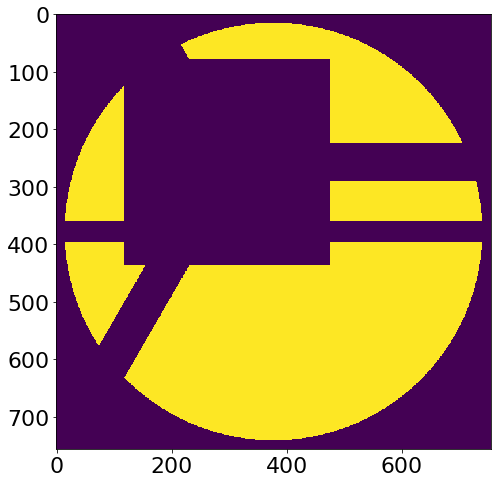

In [124]:
plt.figure(figsize=(8,8))
plt.imshow(pupil.illuminated)

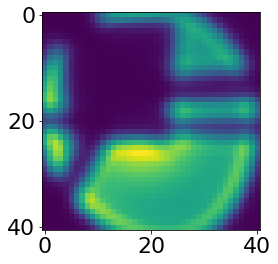

In [125]:
plt.imshow(best_img)

# Nov 11 

In [4]:
#import statments
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=12000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
import time



import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

#np.seterr(divide='ignore', invalid='ignore')

In [5]:
#__all__ = ['PupilFactory', 'Pupil']

class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale

class PupilFactory(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @params others
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.illumminatedFrac=illumminatedFrac
        self.pupilScale = pupilSize/npix
        self.slitFrac=slitFrac
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        

class PFSPupilFactory(PupilFactory):
    """!Pupil obscuration function factory for PFS 
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = (self.pupilSize/2)*self.illumminatedFrac

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        slitFrac = self.slitFrac 
        subaruSlit = slitFrac*subaruRadius
        # meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 
        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius


        
        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 2.62 / 1000 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98


        hscPlateScale = 380  
        thetaX = point.getX() * hscPlateScale 
        thetaY = point.getY() * hscPlateScale 

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        
        #No vignetting for the spectroscope 
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
            
        self._cutRay(pupil, (2,0), Angle(-np.pi),subaruSlit)    
        return pupil

In [248]:
### ZernikeFitter
class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    The centroid parameters are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,
                 jacobian=None,nonUniformEffect=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds (this is spectroscop)
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        """
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        # Note that this is a spectroscop and not an normal optical telescope,
        #so this is not real physical quantity
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        # Again, wavelength - this is a spectroscop
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        if nonUniformEffect is None:
            nonUniformEffect==False
        
        self.kwargs = kwargs
    
    def initParams(self, zmax=4, z4Init=None, centroidInit=None,hscFracInit=None,strutFracInit=None,
                   focalPlanePositionInit=None,diam_sicInit=None,fiber_rInit=None,flux_multInit=None,
                  npixInit=None,side_of_focusInit=None,slitFracInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves.
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscuraded by the camera ()
        @param strutFracInit        Fraction of the pupil obscuraded by the single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Size of the telescope in meters
        @param fiber_rInit          Factor that determines the size of the input fiber
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if centroidInit is None:
            params.add('dx', 0.0)
            params.add('dy', 0.0)
        else:
            params.add('dx', centroidInit[0])
            params.add('dy', centroidInit[1])   
            
        if hscFracInit is None:
            params.add('hscFrac', 0)
        else:
            params.add('hscFrac', hscFracInit)        

        if strutFracInit is None:
            params.add('strutFrac', 0)
        else:
            params.add('strutFrac', strutFracInit)             

        if focalPlanePositionInit is None:
            params.add('dxFocal', 0.0) 
            params.add('dyFocal', 0.0) 
        else:
            params.add('dxFocal', focalPlanePositionInit[0]) 
            params.add('dyFocal', focalPlanePositionInit[1]) 
            
        if diam_sicInit is None:
            params.add('diam_sic', 3.3)
        else:
            params.add('diam_sic', diam_sicInit)   
            
        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
            
        if flux_multInit is None:
            params.add('flux_mult', 1)
        else:
            params.add('flux_mult', flux_multInit)    
        
        if npixInit is None:
            params.add('npix', 512)
        else:
            params.add('npix', npixInit)    
            
        if side_of_focusInit is None:
            params.add('side_of_focus', 1)
        else:
            params.add('side_of_focus', side_of_focusInit)    
            
        if slitFracInit is None:
            params.add('slitFrac', 0)
        else:
            params.add('slitFrac', slitFracInit)     
            
        
        params.add('illumminatedFrac',0.96)        
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        Pupil_Image=PFSPupilFactory(params['diam_sic'.format(i)],params['npix'.format(i)],
                                    params['side_of_focus'.format(i)]*np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],
                                  params['illumminatedFrac'.format(i)],params['slitFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=10240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params,pad_factor=1.5)

    def constructModelImage_PFS(self,params=None,shape=None,pixelScale=None,jacobian=None,nonUniformEffect=False):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)


        #This creates opticalpsf
        if nonUniformEffect==False:
            # 1 component
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
                
                
            optPsf=self._getOptPsf(v)
            optPsf = optPsf.shift(v['dx'], v['dy'])
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*v['fiber_r'])
            final = galsim.Convolve([gal, optPsf])
            modelImg = final.drawImage(
            nx = shape[0],
            ny = shape[1],
            wcs = wcs)
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg.array
        else:
            # 3 components
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
            
                        
            v['illumminatedFrac']=0.96
            optPsf1=self._getOptPsf(v)
            optPsf1 = optPsf1.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=0.986
            optPsf2=self._getOptPsf(v)
            optPsf2 = optPsf2.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=1
            optPsf3=self._getOptPsf(v)
            optPsf3 = optPsf3.shift(v['dx'], v['dy'])
            
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal1 = galsim.TopHat(flux=0.32, radius=(3/8)*(3/2)*v['fiber_r'])
            gal2 = galsim.TopHat(flux=0.334, radius=(3/8)*(3/2)*v['fiber_r'])
            gal3 = galsim.TopHat(flux=0.346, radius=(3/8)*(3/2)*v['fiber_r'])
            
            final1 = galsim.Convolve([gal1, optPsf1])
            final2 = galsim.Convolve([gal2, optPsf2])
            final3 = galsim.Convolve([gal3, optPsf3])
            
            modelImg1 = final1.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg2 = final2.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg3 = final3.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            
            modelImg=np.add(np.add(modelImg1.array,modelImg2.array),modelImg3.array)
            
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg

    
    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
       
# I think I do not need anything below
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

## Creating Scripts

In [166]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

In [167]:
# Create small test script
# Number of free parameters = 27
fiber=0
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TestCode22.sh','w') 

file.write("#!/bin/bash")
file.write("\n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH --ntasks-per-node=2 \n") 
file.write("#SBATCH -t 0:05:00 \n")
file.write("\n")
file.write("#1. zmax (4,11,22)\n") 
file.write("#2. Obs name (3617)\n") 
file.write("#3. Coordinates (e.g., x1626y1588 in early versions, single number in later)\n") 
file.write("#4. Threads \n") 
file.write("#5. Walkers_mult (at least 2) \n")
file.write("#6. Steps \n") 
file.write("#7. Side of focus \n") 
file.write("\n")
for n in single_donut_objects_index[0:2]:
    file.write("python /home/ncaplar/Code/Zernike.py 22 7310 "+str(int(n))+" 16 4 20 1 0\n") 

In [211]:
%%capture
# This creates individual scripts - i made one script per each fiber

single_donut_objects_index_split=np.array_split(single_donut_objects_index,20)
for part in range(0,len(single_donut_objects_index_split)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/7310ScriptPerseusPart'+
                str(part)+'z22.sh','w') 
    
    file.write("#!/bin/bash")
    file.write("\n")
    file.write("#SBATCH -N 1 # node count \n")
    file.write("#SBATCH -N 1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH -t 23:59:00 \n")
    file.write("\n")
    file.write("#1. zmax (4 or 11)\n") 
    file.write("#2. Obs name (3617)\n") 
    file.write("#3. Coordinates (e.g., x1626y1588)\n") 
    file.write("#4. Threads \n") 
    file.write("#5. Walkers_mult (at least 2) \n")
    file.write("#6. Steps \n") 
    file.write("#7. Side of focus 1 or -1 \n")     
    file.write("#8. restart 1 or 0 \n")       
    file.write("\n")
    for object in range(0,len(single_donut_objects_index_split[part])):
        file.write("python /home/ncaplar/Code/Zernike.py 22 7310 "+
                   str(int(single_donut_objects_index_split[part][object]))+" 28 10 200 1 0\n") 
    file.close()  

In [213]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/7310ScriptToSubmitScriptsPerseusNov11'
                +'.sh','w')
file.write("#!/bin/bash")
file.write("\n")

for part in range(0,len(single_donut_objects_index_split)):
    file.write('sbatch /home/ncaplar/Scripts/7310ScriptPerseusPart'+
                str(part)+'z22.sh \n')

## Observing tests

In [214]:
date='Nov10'
date2='Nov11'
run=str(7310)
single_number=str(131)
                
likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+\
                  '/likechain'+date+'_'+run+str(single_number)+'z4.npy')
chichain4=likechain*(-2/(70**2-11))

likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+\
                  '/likechain'+date+'_'+run+str(single_number)+'z11.npy')
chichain11=likechain*(-2/(70**2-18))
likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+\
                 '/likechain'+date+'_'+run+str(single_number)+'z22.npy')
chichain22=likechain*(-2/(70**2-29))


156.498527755


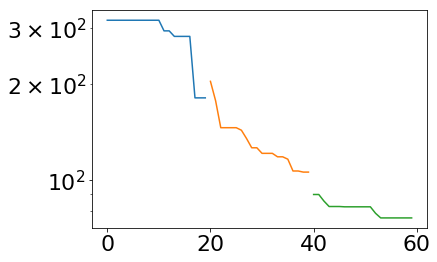

In [215]:
print(np.min(chichain11[-1]))
plt.semilogy(range(0,chichain4.shape[1]),np.apply_along_axis(np.min,0,chichain4))
plt.semilogy(range(chichain4.shape[1],chichain4.shape[1]+chichain11.shape[1]),np.apply_along_axis(np.min,0,chichain11))
plt.semilogy(range(chichain4.shape[1]+chichain11.shape[1],chichain4.shape[1]+chichain11.shape[1]+chichain22.shape[1]),np.apply_along_axis(np.min,0,chichain22))

In [216]:
date='Nov10'
date2='Nov11'
run=str(7310)
single_number=str(131)

chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+'/chain'+date+'_'+run+\
              single_number+'z4.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+'/flatchain'+date+'_'+run+\
              single_number+'z4.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+'/likeflatchain'+date+'_'+run+\
              single_number+'z4.npy')
chiflatchain=likeflatchain*(-2/(70**2-9))
flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]

#This creates flatchain which I think make a lot more sense; you can also define burn fraction
burn_fraction=0.5
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()

    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))


medians=np.apply_along_axis(np.median, 0, flatchain)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     


date='Nov09'
scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/Original/sci'+run+str(single_number)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/Original/var'+run+str(single_number)+'.npy')

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

single_image_analysis.initParams(zmax=4)

#x=manual_medians
x=lowest_chi
single_image_analysis.params['z4'].set(x[0])        
single_image_analysis.params['dx'].set(x[1])
single_image_analysis.params['dy'].set(x[2])
single_image_analysis.params['hscFrac'].set(x[3])
single_image_analysis.params['strutFrac'].set(x[4])
single_image_analysis.params['dxFocal'].set(x[5])
single_image_analysis.params['dyFocal'].set(x[6])
single_image_analysis.params['fiber_r'].set(x[7])
single_image_analysis.params['flux_mult'].set(x[8])
single_image_analysis.params['npix'].set(756)
single_image_analysis.params['side_of_focus'].set(1)
single_image_analysis.params['slitFrac'].set(x[9]) 
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)  

In [217]:
np.min(best_img)

0.097389936

In [218]:
x4=x
print(x4)

[ 12.05569243  -0.64788279   0.18326178   0.86446577   0.23238932
  -0.09028307  -0.36678793   1.00470275   0.83241586   0.00446983]


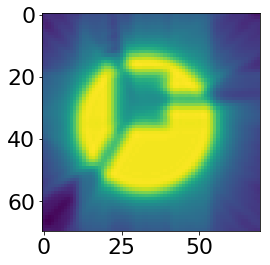

In [219]:
plt.imshow(best_img,norm=LogNorm())

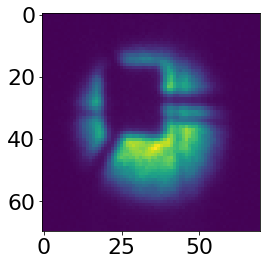

In [220]:
plt.imshow(scidata)

In [221]:
date='Nov10'
date2='Nov11'
run=str(7310)
single_number=str(131)

chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+'/chain'+date+'_'+run+\
              single_number+'z11.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+'/flatchain'+date+'_'+run+\
              single_number+'z11.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+'/likeflatchain'+date+'_'+run+\
              single_number+'z11.npy')
chiflatchain=likeflatchain*(-2/(70**2-17))
flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]

#This creates flatchain which I think make a lot more sense; you can also define burn fraction
burn_fraction=0.5
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()

    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))


medians=np.apply_along_axis(np.median, 0, flatchain)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     


date='Nov09'
scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/Original/sci'+run+str(single_number)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/Original/var'+run+str(single_number)+'.npy')

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

single_image_analysis.initParams(zmax=11)

#x=manual_medians
x=lowest_chi
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['diam_sic'].set(3.3)  
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['hscFrac'].set(x[10])
single_image_analysis.params['strutFrac'].set(x[11])
single_image_analysis.params['dxFocal'].set(x[12])
single_image_analysis.params['dyFocal'].set(x[13])
single_image_analysis.params['fiber_r'].set(x[14])
single_image_analysis.params['flux_mult'].set(x[15])
single_image_analysis.params['npix'].set(756)
single_image_analysis.params['side_of_focus'].set(1)
single_image_analysis.params['slitFrac'].set(x[16]) 
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)  

In [222]:
x11=x
print(x4)
print(x11)

[ 12.05569243  -0.64788279   0.18326178   0.86446577   0.23238932
  -0.09028307  -0.36678793   1.00470275   0.83241586   0.00446983]
[ 12.82122874  -0.04333221  -0.16637495  -0.01172872  -0.06809533
   0.01780702   0.00412177   0.02598976  -0.4969312   -0.13102613
   0.87436067   0.20920953  -0.16072925  -0.27610613   1.00512639
   0.84521802   0.11329635]


In [223]:
np.min(best_img)

0.09802825

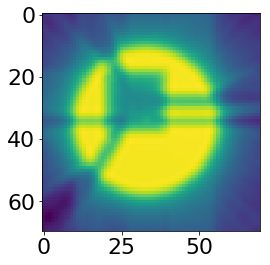

In [224]:
plt.imshow(best_img,norm=LogNorm())

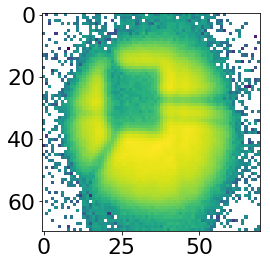

In [226]:
plt.imshow(scidata,norm=LogNorm())

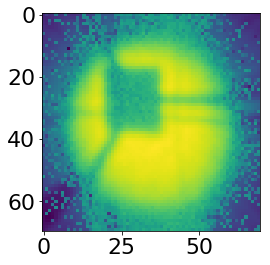

In [227]:
date='Nov10'
date2='Nov11'
run=str(7310)
single_number=str(131)

chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+'/chain'+date+'_'+run+\
              single_number+'z22.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+'/flatchain'+date+'_'+run+\
              single_number+'z22.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date2+'/likeflatchain'+date+'_'+run+\
              single_number+'z22.npy')
chiflatchain=likeflatchain*(-2/(70**2-28))
flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]

#This creates flatchain which I think make a lot more sense; you can also define burn fraction
burn_fraction=0.5
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()

    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))


medians=np.apply_along_axis(np.median, 0, flatchain)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     


date='Nov09'
scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/Original/sci'+run+str(single_number)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/Original/var'+run+str(single_number)+'.npy')

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

single_image_analysis.initParams(zmax=22)

#x=manual_medians
x=lowest_chi
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['diam_sic'].set(3.3)  
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['z12'].set(x[8])
single_image_analysis.params['z13'].set(x[9])
single_image_analysis.params['z14'].set(x[10])
single_image_analysis.params['z15'].set(x[11])
single_image_analysis.params['z16'].set(x[12])
single_image_analysis.params['z17'].set(x[13])
single_image_analysis.params['z18'].set(x[14])
single_image_analysis.params['z19'].set(x[15])      
single_image_analysis.params['z20'].set(x[16])
single_image_analysis.params['z21'].set(x[17]) 
single_image_analysis.params['z22'].set(x[18]) 
single_image_analysis.params['dx'].set(x[19])
single_image_analysis.params['dy'].set(x[20])
single_image_analysis.params['hscFrac'].set(x[21])
single_image_analysis.params['strutFrac'].set(x[22])
single_image_analysis.params['dxFocal'].set(x[23])
single_image_analysis.params['dyFocal'].set(x[24])
single_image_analysis.params['fiber_r'].set(x[25])
single_image_analysis.params['flux_mult'].set(x[26])
single_image_analysis.params['slitFrac'].set(x[27])  
single_image_analysis.params['npix'].set(756)
single_image_analysis.params['side_of_focus'].set(1)

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)  





In [230]:
x22=x
print(x4)
print(x11)
print(x22)

[ 12.05569243  -0.64788279   0.18326178   0.86446577   0.23238932
  -0.09028307  -0.36678793   1.00470275   0.83241586   0.00446983]
[ 12.82122874  -0.04333221  -0.16637495  -0.01172872  -0.06809533
   0.01780702   0.00412177   0.02598976  -0.4969312   -0.13102613
   0.87436067   0.20920953  -0.16072925  -0.27610613   1.00512639
   0.84521802   0.11329635]
[ 12.82585302   0.15107917   0.2160261   -0.08683175   0.18594391
   0.11407496   0.08209426  -0.09105469   0.05239003   0.0290281
  -0.02306999  -0.12055818   0.08082124   0.02143751  -0.02940627
  -0.00606202   0.02876354  -0.02861379   0.26647001  -0.59008946
  -0.20047747   0.90490352   0.18498863  -0.16392435  -0.30888536
   0.969908     0.91424179   0.11106561]


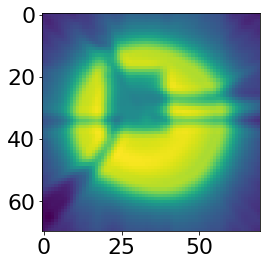

In [228]:
plt.imshow(best_img,norm=LogNorm())

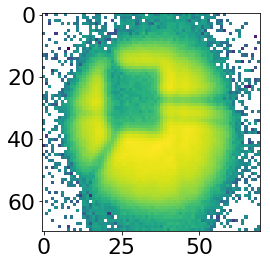

In [229]:
plt.imshow(scidata,norm=LogNorm())

In [235]:
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['diam_sic'].set(3.3)  
single_image_analysis.params['z5'].set(3)
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['z12'].set(x[8])
single_image_analysis.params['z13'].set(x[9])
single_image_analysis.params['z14'].set(x[10])
single_image_analysis.params['z15'].set(x[11])
single_image_analysis.params['z16'].set(x[12])
single_image_analysis.params['z17'].set(0)
single_image_analysis.params['z18'].set(x[14])
single_image_analysis.params['z19'].set(x[15])      
single_image_analysis.params['z20'].set(x[16])
single_image_analysis.params['z21'].set(x[17]) 
single_image_analysis.params['z22'].set(x[18]) 
single_image_analysis.params['dx'].set(x[19])
single_image_analysis.params['dy'].set(x[20])
single_image_analysis.params['hscFrac'].set(x[21])
single_image_analysis.params['strutFrac'].set(x[22])
single_image_analysis.params['dxFocal'].set(x[23])
single_image_analysis.params['dyFocal'].set(x[24])
single_image_analysis.params['fiber_r'].set(x[25])
single_image_analysis.params['flux_mult'].set(x[26])
single_image_analysis.params['slitFrac'].set(x[27])  
single_image_analysis.params['npix'].set(756)
single_image_analysis.params['side_of_focus'].set(1)
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)  


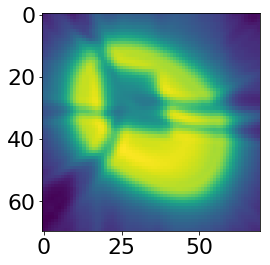

In [236]:
plt.imshow(best_img,norm=LogNorm())

In [ ]:
create_par_Init_keep_values

## Analysis 

### z4

In [9]:
date='Nov11'
zOrder='z4'
import glob
import os
import string
os.chdir("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/"+date+"/")
list_of_chains=glob.glob("chain*"+zOrder+".npy")

In [10]:
single_donut_objects_index_analyzed=\
np.array((map(lambda x: int(string.split(string.split(x,'7310')[1],'z')[0]), list_of_chains)))

In [11]:
len(single_donut_objects_index_analyzed)

100

In [30]:
#Creating procedures for z4 case
    
def create_model_post(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                  '/chain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                      '/flatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                          '/likeflatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    
    chiflatchain=likeflatchain*(-2/(scidata.shape[0]**2-9))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    
    # Size of the pupil image 
    npixInit=756
    # Which side of focus we are on
    side_of_focusInit=int(1)
    
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            

    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
    single_image_analysis.initParams(zmax=int(zOrder[1:len(zOrder)]))

    #x=manual_medians
    x=lowest_chi
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['diam_sic'].set(3.3)            
    single_image_analysis.params['dx'].set(x[1])
    single_image_analysis.params['dy'].set(x[2])
    single_image_analysis.params['hscFrac'].set(x[3])
    single_image_analysis.params['strutFrac'].set(x[4])
    single_image_analysis.params['dxFocal'].set(x[5])
    single_image_analysis.params['dyFocal'].set(x[6])
    single_image_analysis.params['fiber_r'].set(x[7])
    single_image_analysis.params['flux_mult'].set(x[8])
    single_image_analysis.params['slitFrac'].set(x[9])
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)  

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(single_number),best_img)
    
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['diam_sic'].set(3.3)            
    single_image_analysis.params['dx'].set(x[1])
    single_image_analysis.params['dy'].set(x[2])
    single_image_analysis.params['hscFrac'].set(x[3])
    single_image_analysis.params['strutFrac'].set(x[4])
    single_image_analysis.params['dxFocal'].set(x[5])
    single_image_analysis.params['dyFocal'].set(x[6])
    single_image_analysis.params['fiber_r'].set(x[7])
    single_image_analysis.params['flux_mult'].set(x[8])
    single_image_analysis.params['slitFrac'].set(x[9])
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)  

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
#    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model0/'+str(single_number),best_img)
    
    
    Pupil_data=PFSPupilFactory(single_image_analysis.params['diam_sic'.format(i)].value,single_image_analysis.params['npix'.format(i)],
                               single_image_analysis.params['side_of_focus'.format(i)]*np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value,0.96,
                               single_image_analysis.params['slitFrac'.format(i)])
    point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
    pupil=Pupil_data.getPupil(point)
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Pupil/'+str(single_number),pupil.illuminated)


def create_residual_post(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Residual/'+str(single_number),scidata-modeldata)
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Chi/'+str(single_number),((scidata-modeldata)**2)/vardata) 
    
def create_maxvalue(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(single_number)+'.npy')
    maxvalue=np.max(scidata)*1.01
    np.save('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/maxvalue'+str(single_number),maxvalue)    
    

In [31]:
%%capture
map(create_maxvalue, single_donut_objects_index_analyzed)

In [32]:
%%capture
import multiprocessing
pool = multiprocessing.Pool()
pool.map(create_model_post, single_donut_objects_index_analyzed)
pool.close

In [34]:
%%capture
map(create_residual_post,single_donut_objects_index_analyzed)

#### Display images

In [35]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

if len(single_donut_objects_index_analyzed)==len(single_donut_objects_index):
    single_donut_objects_index_analyzed=single_donut_objects_index


In [36]:
def show_images(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0007310, "+str(save), fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
 #        if image.ndim == 2:
 #            plt.gray()
        if save=='Residuals, rescaled':
            plt.imshow(image)
        else:
            plt.imshow(np.abs(image),vmax=maxvalue/maxValueDivision)
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Summary/'+str(save))
      

In [37]:
def show_images_log(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0007310, "+str(save)+' /Log scaling', fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
 #        if image.ndim == 2:
 #            plt.gray()
        plt.imshow(np.abs(image),vmin=1,vmax=maxvalue/maxValueDivision, norm=LogNorm())
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Summary/'+str(save)+' Log')
      

In [38]:
list_of_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_images.append(np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(int(i))+'.npy'))

list_of_maxvalues=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_maxvalues.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/maxvalue'+str(int(i))+'.npy'))        

#list_of_titles=[]
#for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended_full)):
#    for j in range (0,len(single_number_for_single_pos_single_donut_split_by_y_appended_full[i])):
#        list_of_titles.append(str((int(single_number_for_single_pos_single_donut_split_by_y_appended_full[i][j][3]),
#                           int(4175-single_number_for_single_pos_single_donut_split_by_y_appended_full[i][j][4]))))
        
list_of_titles=[]
for i in list(single_donut_objects_index_analyzed):
    single_number_for_single_pos_full_analyzed_row=\
    single_number_for_single_pos_full[single_number_for_single_pos_full[:,0]==i]
    list_of_titles.append(str((int(single_number_for_single_pos_full_analyzed_row[0][3]),
                           int(4175-single_number_for_single_pos_full_analyzed_row[0][4]))))    

In [40]:
list_of_model_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_model_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(int(i))+'.npy'))        
    
        
list_of_residual_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_residual_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Residual/'+str(int(i))+'.npy'))     
    
                
list_of_pupil_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_pupil_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Pupil/'+str(int(i))+'.npy'))         
    
list_of_model0_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_model0_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model0/'+str(int(i))+'.npy'))      
        
    
list_of_maxvalues_pupil=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_maxvalues_pupil.append(2)  

In [42]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [43]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [44]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [45]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [46]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [47]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [48]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, rescaled',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [49]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_pupil_images[0:how_many_images],
            int(how_many_images/10),save='Pupils',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues_pupil[0:how_many_images],maxValueDivision=2)

### z11

In [50]:
date='Nov11'
zOrder='z11'
import glob
import os
import string
os.chdir("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/"+date+"/")
list_of_chains=glob.glob("chain*"+zOrder+".npy")

In [51]:
single_donut_objects_index_analyzed=\
np.array((map(lambda x: int(string.split(string.split(x,'7310')[1],'z')[0]), list_of_chains)))

In [52]:
len(single_donut_objects_index_analyzed)

100

In [59]:
#Creating procedures for z4 case
    
def create_model_post(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                  '/chain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                      '/flatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                          '/likeflatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    
    chiflatchain=likeflatchain*(-2/(scidata.shape[0]**2-9))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    
    # Size of the pupil image 
    npixInit=756
    # Which side of focus we are on
    side_of_focusInit=int(1)
    
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            

    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
    single_image_analysis.initParams(zmax=int(zOrder[1:len(zOrder)]))

    #x=manual_medians
    x=lowest_chi
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['diam_sic'].set(3.3)  
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['fiber_r'].set(x[14])
    single_image_analysis.params['flux_mult'].set(x[15])
    single_image_analysis.params['slitFrac'].set(x[16]) 
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)  

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(single_number),best_img)
    
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['diam_sic'].set(3.3)  
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['fiber_r'].set(x[14])
    single_image_analysis.params['flux_mult'].set(x[15])
    single_image_analysis.params['slitFrac'].set(x[16])  
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)  

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
#    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model0/'+str(single_number),best_img)
    
    
    Pupil_data=PFSPupilFactory(single_image_analysis.params['diam_sic'.format(i)].value,single_image_analysis.params['npix'.format(i)],
                               single_image_analysis.params['side_of_focus'.format(i)]*np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value,0.96,
                               single_image_analysis.params['slitFrac'.format(i)])
    point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
    pupil=Pupil_data.getPupil(point)
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Pupil/'+str(single_number),pupil.illuminated)


def create_residual_post(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Residual/'+str(single_number),scidata-modeldata)
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Chi/'+str(single_number),((scidata-modeldata)**2)/vardata) 
    
def create_maxvalue(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(single_number)+'.npy')
    maxvalue=np.max(scidata)*1.01
    np.save('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/maxvalue'+str(single_number),maxvalue)    
    

In [60]:
%%capture
map(create_maxvalue, single_donut_objects_index_analyzed)

In [61]:
%%capture
import multiprocessing
pool = multiprocessing.Pool()
pool.map(create_model_post, single_donut_objects_index_analyzed)
pool.close

In [62]:
%%capture
map(create_residual_post,single_donut_objects_index_analyzed)

#### Display images

In [63]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

if len(single_donut_objects_index_analyzed)==len(single_donut_objects_index):
    single_donut_objects_index_analyzed=single_donut_objects_index


In [64]:
def show_images(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0007310, "+str(save), fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
 #        if image.ndim == 2:
 #            plt.gray()
        if save=='Residuals, rescaled':
            plt.imshow(image)
        else:
            plt.imshow(np.abs(image),vmax=maxvalue/maxValueDivision)
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Summary/'+str(save))
      

In [65]:
def show_images_log(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0007310, "+str(save)+' /Log scaling', fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
 #        if image.ndim == 2:
 #            plt.gray()
        plt.imshow(np.abs(image),vmin=1,vmax=maxvalue/maxValueDivision, norm=LogNorm())
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Summary/'+str(save)+' Log')
      

In [66]:
list_of_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_images.append(np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(int(i))+'.npy'))

list_of_maxvalues=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_maxvalues.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/maxvalue'+str(int(i))+'.npy'))        

#list_of_titles=[]
#for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended_full)):
#    for j in range (0,len(single_number_for_single_pos_single_donut_split_by_y_appended_full[i])):
#        list_of_titles.append(str((int(single_number_for_single_pos_single_donut_split_by_y_appended_full[i][j][3]),
#                           int(4175-single_number_for_single_pos_single_donut_split_by_y_appended_full[i][j][4]))))
        
list_of_titles=[]
for i in list(single_donut_objects_index_analyzed):
    single_number_for_single_pos_full_analyzed_row=\
    single_number_for_single_pos_full[single_number_for_single_pos_full[:,0]==i]
    list_of_titles.append(str((int(single_number_for_single_pos_full_analyzed_row[0][3]),
                           int(4175-single_number_for_single_pos_full_analyzed_row[0][4]))))    

In [67]:
list_of_model_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_model_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(int(i))+'.npy'))        
    
        
list_of_residual_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_residual_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Residual/'+str(int(i))+'.npy'))     
    
                
list_of_pupil_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_pupil_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Pupil/'+str(int(i))+'.npy'))         
    
list_of_model0_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_model0_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model0/'+str(int(i))+'.npy'))      
        
    
list_of_maxvalues_pupil=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_maxvalues_pupil.append(2)  

In [68]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [69]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [70]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [71]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [72]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [73]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [74]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, rescaled',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [75]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_pupil_images[0:how_many_images],
            int(how_many_images/10),save='Pupils',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues_pupil[0:how_many_images],maxValueDivision=2)

### z22

In [94]:
date='Nov11'
zOrder='z22'
import glob
import os
import string
os.chdir("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/"+date+"/")
list_of_chains=glob.glob("chain*"+zOrder+".npy")

In [95]:
single_donut_objects_index_analyzed=\
np.array((map(lambda x: int(string.split(string.split(x,'7310')[1],'z')[0]), list_of_chains)))

In [96]:
len(single_donut_objects_index_analyzed)

100

In [97]:
#Creating procedures 
    
def create_model_post(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                  '/chain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                      '/flatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                          '/likeflatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    
    chiflatchain=likeflatchain*(-2/(scidata.shape[0]**2-9))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    
    # Size of the pupil image 
    npixInit=756
    # Which side of focus we are on
    side_of_focusInit=int(1)
    
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            

    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
    single_image_analysis.initParams(zmax=int(zOrder[1:len(zOrder)]))

    #x=manual_medians
    x=lowest_chi
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['diam_sic'].set(3.3)  
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['z12'].set(x[8])
    single_image_analysis.params['z13'].set(x[9])
    single_image_analysis.params['z14'].set(x[10])
    single_image_analysis.params['z15'].set(x[11])
    single_image_analysis.params['z16'].set(x[12])
    single_image_analysis.params['z17'].set(x[13])
    single_image_analysis.params['z18'].set(x[14])
    single_image_analysis.params['z19'].set(x[15])      
    single_image_analysis.params['z20'].set(x[16])
    single_image_analysis.params['z21'].set(x[17]) 
    single_image_analysis.params['z22'].set(x[18]) 
    single_image_analysis.params['dx'].set(x[19])
    single_image_analysis.params['dy'].set(x[20])
    single_image_analysis.params['hscFrac'].set(x[21])
    single_image_analysis.params['strutFrac'].set(x[22])
    single_image_analysis.params['dxFocal'].set(x[23])
    single_image_analysis.params['dyFocal'].set(x[24])
    single_image_analysis.params['fiber_r'].set(x[25])
    single_image_analysis.params['flux_mult'].set(x[26])
    single_image_analysis.params['slitFrac'].set(x[27]) 
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)  

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(single_number),best_img)
    
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['diam_sic'].set(3.3)  
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['z12'].set(x[8])
    single_image_analysis.params['z13'].set(x[9])
    single_image_analysis.params['z14'].set(x[10])
    single_image_analysis.params['z15'].set(x[11])
    single_image_analysis.params['z16'].set(x[12])
    single_image_analysis.params['z17'].set(x[13])
    single_image_analysis.params['z18'].set(x[14])
    single_image_analysis.params['z19'].set(x[15])      
    single_image_analysis.params['z20'].set(x[16])
    single_image_analysis.params['z21'].set(x[17]) 
    single_image_analysis.params['z22'].set(x[18]) 
    single_image_analysis.params['dx'].set(x[19])
    single_image_analysis.params['dy'].set(x[20])
    single_image_analysis.params['hscFrac'].set(x[21])
    single_image_analysis.params['strutFrac'].set(x[22])
    single_image_analysis.params['dxFocal'].set(x[23])
    single_image_analysis.params['dyFocal'].set(x[24])
    single_image_analysis.params['fiber_r'].set(x[25])
    single_image_analysis.params['flux_mult'].set(x[26])
    single_image_analysis.params['slitFrac'].set(x[27]) 
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)  

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
#    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model0/'+str(single_number),best_img)
    
    
    Pupil_data=PFSPupilFactory(single_image_analysis.params['diam_sic'.format(i)].value,single_image_analysis.params['npix'.format(i)],
                               single_image_analysis.params['side_of_focus'.format(i)]*np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value,0.96,
                               single_image_analysis.params['slitFrac'.format(i)])
    point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
    pupil=Pupil_data.getPupil(point)
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Pupil/'+str(single_number),pupil.illuminated)


def create_residual_post(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Residual/'+str(single_number),scidata-modeldata)
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Chi/'+str(single_number),((scidata-modeldata)**2)/vardata) 
    
def create_maxvalue(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(single_number)+'.npy')
    maxvalue=np.max(scidata)*1.01
    np.save('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/maxvalue'+str(single_number),maxvalue)    
    

In [98]:
%%capture
map(create_maxvalue, single_donut_objects_index_analyzed)

In [99]:
%%capture
import multiprocessing
pool = multiprocessing.Pool()
pool.map(create_model_post, single_donut_objects_index_analyzed)
pool.close

In [100]:
%%capture
map(create_residual_post,single_donut_objects_index_analyzed)

#### Display images

In [101]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

if len(single_donut_objects_index_analyzed)==len(single_donut_objects_index):
    single_donut_objects_index_analyzed=single_donut_objects_index


In [141]:
def show_images(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0007310, "+str(save), fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
 #        if image.ndim == 2:
 #            plt.gray()
        if save=='Residuals, rescaled':
            plt.imshow(image)
        else:
            if save=='Chi':
                plt.imshow(image)
            else:
                plt.imshow(np.abs(image),vmax=maxvalue/maxValueDivision)
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Summary/'+str(save))
      

In [103]:
def show_images_log(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0007310, "+str(save)+' /Log scaling', fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
 #        if image.ndim == 2:
 #            plt.gray()
        plt.imshow(np.abs(image),vmin=1,vmax=maxvalue/maxValueDivision, norm=LogNorm())
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Summary/'+str(save)+' Log')
      

In [104]:
list_of_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_images.append(np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(int(i))+'.npy'))

list_of_maxvalues=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_maxvalues.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/maxvalue'+str(int(i))+'.npy'))        

#list_of_titles=[]
#for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended_full)):
#    for j in range (0,len(single_number_for_single_pos_single_donut_split_by_y_appended_full[i])):
#        list_of_titles.append(str((int(single_number_for_single_pos_single_donut_split_by_y_appended_full[i][j][3]),
#                           int(4175-single_number_for_single_pos_single_donut_split_by_y_appended_full[i][j][4]))))
        
list_of_titles=[]
for i in list(single_donut_objects_index_analyzed):
    single_number_for_single_pos_full_analyzed_row=\
    single_number_for_single_pos_full[single_number_for_single_pos_full[:,0]==i]
    list_of_titles.append(str((int(single_number_for_single_pos_full_analyzed_row[0][3]),
                           int(4175-single_number_for_single_pos_full_analyzed_row[0][4]))))    

In [140]:
list_of_model_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_model_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(int(i))+'.npy'))        
    
        
list_of_residual_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_residual_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Residual/'+str(int(i))+'.npy'))     
    
                
list_of_pupil_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_pupil_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Pupil/'+str(int(i))+'.npy'))         
    
list_of_model0_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_model0_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model0/'+str(int(i))+'.npy'))      

list_of_chi_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_chi_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Chi/'+str(int(i))+'.npy'))      
    
list_of_maxvalues_pupil=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_maxvalues_pupil.append(2)  

In [106]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [107]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [108]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [109]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [110]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [111]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [112]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, rescaled',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [113]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_pupil_images[0:how_many_images],
            int(how_many_images/10),save='Pupils',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues_pupil[0:how_many_images],maxValueDivision=2)

In [142]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_chi_images[0:how_many_images],
            int(how_many_images/10),save='Chi',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues_pupil[0:how_many_images],maxValueDivision=1)

### Parameter dependance

In [ ]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

if len(single_donut_objects_index_analyzed)==len(single_donut_objects_index):
    single_donut_objects_index_analyzed=single_donut_objects_index

In [115]:
def lowest_chi_par(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                  '/chain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                      '/flatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                          '/likeflatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    
    chiflatchain=likeflatchain*(-2/(70**2-28))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    
 
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            
    medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    # Possible problem - likelihood has different shape than chain!    
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     
    low_chi=np.min(-likeflatchain)*(2)/(70**2-28)
    maxchi2=np.sum(scidata**2/vardata)/(70**2-28)
    
    #help_array=np.append(np.append(lowest_chi,low_chi),maxchi2)
    help_array=np.append(np.append(lowest_chi,low_chi),maxchi2)
    return np.append(help_array,single_number_for_single_pos_full[single_number_for_single_pos_full[:,0]==single_number])
    

In [123]:
lowest_chi_pos=[]
for i in single_donut_objects_index_analyzed:
    lowest_chi_pos=np.append(lowest_chi_pos,lowest_chi_par(int(i)))

lowest_chi_pos=lowest_chi_pos.reshape(len(single_donut_objects_index_analyzed),int(len(lowest_chi_pos)/len(single_donut_objects_index_analyzed)))
#Switch y axis from numpy to chip counting
lowest_chi_pos[:,34]=4175-lowest_chi_pos[:,34]

np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+'/lowest_chi_pos',lowest_chi_pos)

In [124]:
descriptions=['0_z4','1_z5','2_z6','3_z7','4_z8','5_z9','6_z10','7_z11','8_z12','9_z13','10_z14','11_z15','12_z16',
              '13_z17','14_z18','15_z19','16_z20','17_z21','18_z22','19_dx','20_dy','21_hscFrac','22_strutFrac',
              '23_dxFocal','24_dyFocal','25_rfiber','26_fluxmult','27_slitFrac','28_chi**2 per d.o.f.','29_maxchi**2 per d.o.f.',
              '30_unique index','31_fiber', '32_spot index', '33_xpos', '34_ypos']

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

for i in range(0,len(descriptions)):

    N = len(single_donut_objects_index_analyzed)
    x = lowest_chi_pos[:,33]
    y = lowest_chi_pos[:,34]
    colors = lowest_chi_pos[:,i]
    area = np.pi * (15 * 1)**2  # 0 to 15 point radii

    if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])[0] == True:
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
            abs_max_colors=max(np.abs(colors))
            max_colors=0.5
            min_colors=-0.5
        else:
            abs_max_colors=max(np.abs(colors))
            max_colors=0.1
            min_colors=-0.1
    else:   
        max_colors=max(colors)
        min_colors=min(colors)

    plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
    plt.ylim(0,4416)
    plt.xlim(0,4294)
    plt.xlabel('x position on chip')
    plt.ylabel('y position on chip')
    plt.title(descriptions[i].split("_")[1])


    plt.colorbar()
    #plt.show()
    plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/z22/Summary/'+str(descriptions[i]))
    plt.clf()    

## Corner plot - one example

In [131]:
single_number=73
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/flatchain'+date+'_7310'\
          +str(single_number)+'z22.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/likeflatchain'+date+
                      '_7310'+str(single_number)+'z22.npy')
flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
chiflatchain=likeflatchain*(-2/(70**2-28))
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     
low_chi=np.min(-likeflatchain)*(2)/(70**2-28)
print(lowest_chi)

[ 12.45456369  -0.12645194  -0.49898743   0.03230924  -0.07902888
   0.00921599  -0.21080952   0.07927646  -0.01555763  -0.01903023
  -0.05535031   0.02068376   0.00034258   0.00954769   0.04111584
  -0.00776356  -0.03404122   0.00885578   0.13028773   0.6918882
   0.01747588   0.95140792   0.149927    -0.06177068   0.03327493
   1.07926658   0.95616425   0.05839735]


In [130]:
%%capture
import corner
matplotlib.rcParams.update({'font.size': 16})
figure=corner.corner(flatchain, labels=descriptions[0:28],
                  truths=list(lowest_chi))
figure.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/parameters.png')

In [132]:
%%capture
import corner
matplotlib.rcParams.update({'font.size': 16})
figure=corner.corner(flatchain_low, labels=descriptions[0:28],
                  truths=list(lowest_chi))
figure.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/parameters_low.png')

In [133]:
descriptions[0:28]

['0_z4',
 '1_z5',
 '2_z6',
 '3_z7',
 '4_z8',
 '5_z9',
 '6_z10',
 '7_z11',
 '8_z12',
 '9_z13',
 '10_z14',
 '11_z15',
 '12_z16',
 '13_z17',
 '14_z18',
 '15_z19',
 '16_z20',
 '17_z21',
 '18_z22',
 '19_dx',
 '20_dy',
 '21_hscFrac',
 '22_strutFrac',
 '23_dxFocal',
 '24_dyFocal',
 '25_rfiber',
 '26_fluxmult',
 '27_slitFrac']

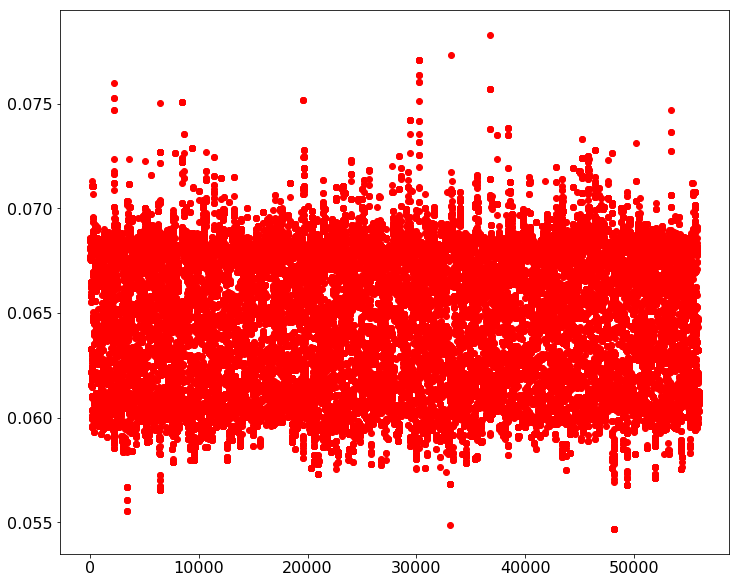

In [136]:
plt.plot(flatchain[:,27],'ro')

## Chi evolution 

In [137]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

In [ ]:
date='Nov11'
run=str(7310)
single_number=str(130)
                
likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                  '/likechain'+date+'_'+run+str(single_number)+'z4.npy')
chichain4=likechain*(-2/(70**2-10))

likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                  '/likechain'+date+'_'+run+str(single_number)+'z11.npy')
chichain11=likechain*(-2/(70**2-17))
likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                 '/likechain'+date+'_'+run+str(single_number)+'z22.npy')
chichain22=likechain*(-2/(70**2-28))


In [139]:
date='Nov11'
run=str(7310)
for i in single_donut_objects_index:
    single_number=str(int(i))               
    likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                      '/likechain'+date+'_'+run+str(single_number)+'z4.npy')
    chichain4=likechain*(-2/(70**2-10))

    likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                      '/likechain'+date+'_'+run+str(single_number)+'z11.npy')
    chichain11=likechain*(-2/(70**2-17))
    likechain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+\
                     '/likechain'+date+'_'+run+str(single_number)+'z22.npy')
    chichain22=likechain*(-2/(70**2-28))
    plt.ylim(1,10000)
    plt.semilogy(range(0,chichain4.shape[1]),np.apply_along_axis(np.min,0,chichain4))
    plt.semilogy(range(chichain4.shape[1],chichain4.shape[1]+chichain11.shape[1]),np.apply_along_axis(np.min,0,chichain11))
    plt.semilogy(range(chichain4.shape[1]+chichain11.shape[1],chichain4.shape[1]+chichain11.shape[1]+chichain22.shape[1]),np.apply_along_axis(np.min,0,chichain22))
    plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Nov11/z22/Chi_Plot/'+str(int(i))+'.png')
    plt.clf()

## Predicting in focus

### Only dx, dy

In [64]:
#Creating procedures for 0 case
    
def create_model_post0(single_number,dx,dy):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/chainNov11_7310'
                  +str(single_number)+'z22.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/flatchainNov11_7310'
              +str(single_number)+'z22.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/likeflatchainNov11_7310'+str(single_number)+'z22.npy')
    chiflatchain=likeflatchain*(-2/(70**2-27))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    
    # Size of the pupil image 
    npixInit=100
    # Which side of focus we are on
    side_of_focusInit=int(1)
    
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            

    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     
    
    scidata=np.ones((13,13))
    vardata=np.ones((13,13))
    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

    single_image_analysis.initParams(zmax=22)

    x=lowest_chi
    single_image_analysis.params['z4'].set(0)
    single_image_analysis.params['diam_sic'].set(3.3)  
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['z12'].set(x[8])
    single_image_analysis.params['z13'].set(x[9])
    single_image_analysis.params['z14'].set(x[10])
    single_image_analysis.params['z15'].set(x[11])
    single_image_analysis.params['z16'].set(x[12])
    single_image_analysis.params['z17'].set(x[13])
    single_image_analysis.params['z18'].set(x[14])
    single_image_analysis.params['z19'].set(x[15])      
    single_image_analysis.params['z20'].set(x[16])
    single_image_analysis.params['z21'].set(x[17]) 
    single_image_analysis.params['z22'].set(x[18]) 
    single_image_analysis.params['dx'].set(dx)
    single_image_analysis.params['dy'].set(dy)
    single_image_analysis.params['hscFrac'].set(x[21])
    single_image_analysis.params['strutFrac'].set(x[22])
    single_image_analysis.params['dxFocal'].set(x[23])
    single_image_analysis.params['dyFocal'].set(x[24])
    single_image_analysis.params['fiber_r'].set(x[25])
    single_image_analysis.params['flux_mult'].set(x[26])
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)    

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
    return best_img


In [77]:
i=66
test_img=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7296'+str(int(i))+'.npy')
pos_of_max_flux=np.where(test_img==np.max(test_img))
pos_of_max_flux=map(int,pos_of_max_flux)
test_img_zoom=test_img[pos_of_max_flux[0]-6:pos_of_max_flux[0]+7,pos_of_max_flux[1]-6:pos_of_max_flux[1]+7]
test_img_zoom_flux=np.sum(test_img_zoom)

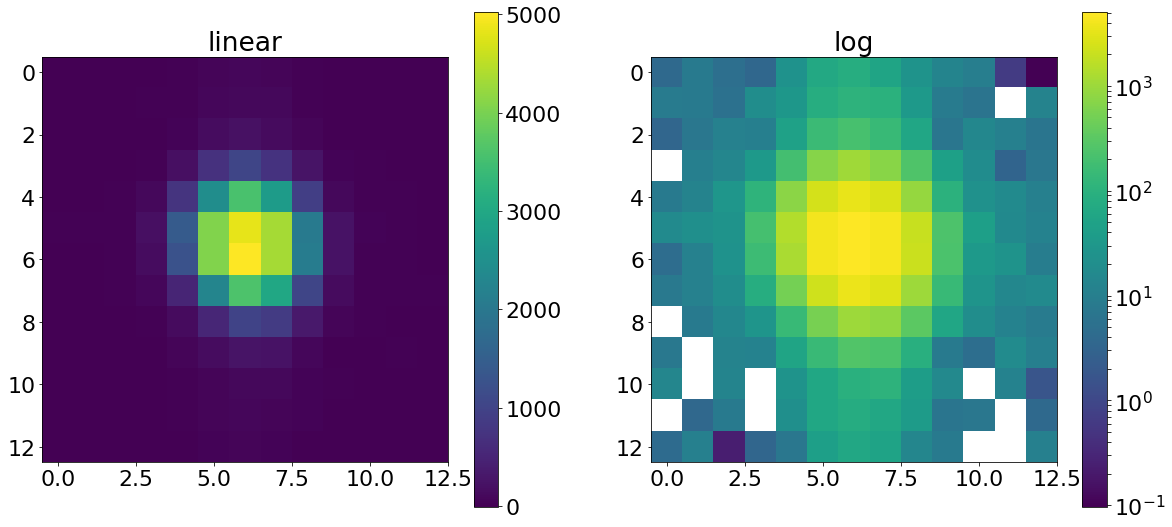

In [80]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img_zoom)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(test_img_zoom, norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [67]:
paramsp = lmfit.Parameters()
paramsp.add('dxp', 0.0)
paramsp.add('dyp', 0.0)

In [81]:
def residual(pars,i):
    # unpack parameters:
    #  extract .value attribute for each parameter
    parvals = pars.valuesdict()
    dxp = parvals['dxp']
    dyp = parvals['dyp']
    test_img=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7296'+str(int(i))+'.npy')
    pos_of_max_flux=np.where(test_img==np.max(test_img))
    pos_of_max_flux=map(int,pos_of_max_flux)
    test_img_zoom=test_img[pos_of_max_flux[0]-6:pos_of_max_flux[0]+7,pos_of_max_flux[1]-6:pos_of_max_flux[1]+7]
    test_img_zoom_flux=np.sum(test_img_zoom)
    model = create_model_post0(i,dxp,dyp)
    model=model*(test_img_zoom_flux/np.sum(model))
    print(np.sum(abs(model - test_img_zoom))/np.sum(test_img_zoom))    
    return (model - test_img_zoom)/1

In [82]:
fitter=lmfit.Minimizer(residual,paramsp,fcn_args=[i])

In [83]:
fitter.minimize()

0.45591
0.45591
0.45591
0.45573
0.456321
0.451387
0.451387
0.451389
0.442709
0.442708
0.442713
0.427714
0.427712
0.427721
0.403394
0.40339
0.403404
0.356067
0.356059
0.356093
0.298613
0.298597
0.298641
0.284298
0.284285
0.284302
0.282997
0.282986
0.283
0.282594
0.282583
0.282598
0.282574
0.282563
0.282579
0.282489
0.282478
0.282494
0.28251
0.282499
0.282515
0.282634
0.282634
0.282561
0.28253
0.282516
0.282505
0.282522
0.282521
0.282518
0.282516
0.282516


In [84]:
test_model0F=create_model_post0(i,fitter.values['dxp'],fitter.values['dyp'])
test_model0F=test_model0F*(np.sum(test_img_zoom)/np.sum(test_model0F))

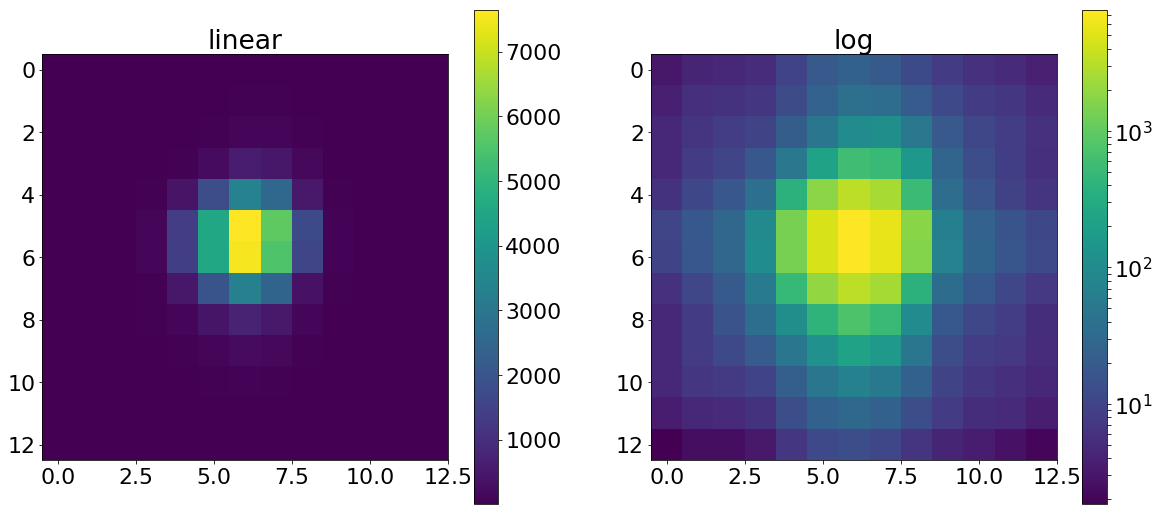

In [85]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_model0F)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(test_model0F, norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

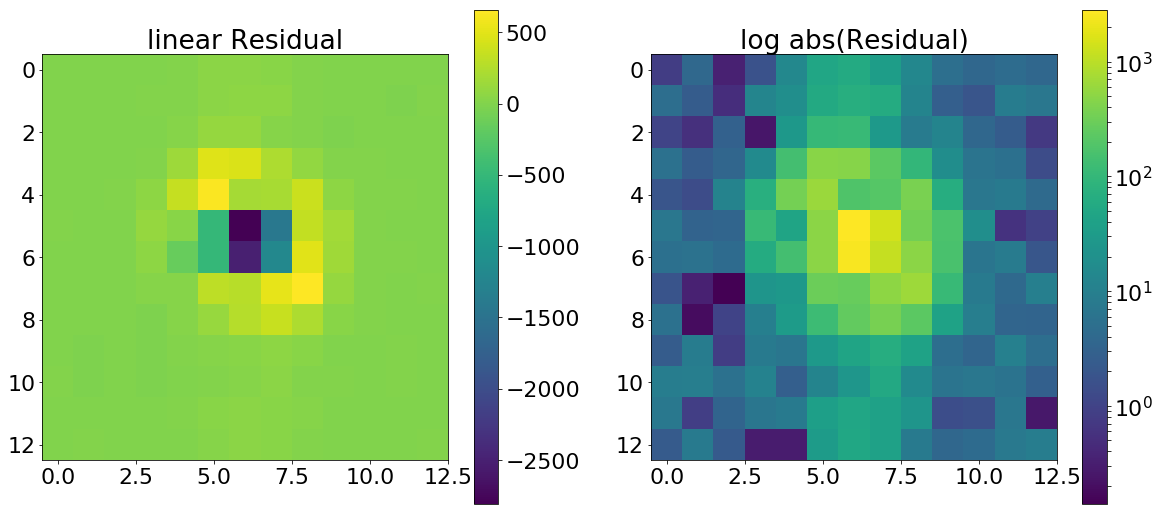

In [86]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img_zoom-test_model0F)
plt.colorbar()
plt.title('linear Residual')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.abs(test_img_zoom-test_model0F), norm=LogNorm())
plt.colorbar()
plt.title('log abs(Residual)')
plt.grid(False)

### dx, dy, focus, r_fiber

In [430]:
#Creating procedures for 0 case
    
def create_model_post0(single_number,dx,dy,z4,fp):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/chainNov11_7310'
                  +str(single_number)+'z22.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/flatchainNov11_7310'
              +str(single_number)+'z22.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/likeflatchainNov11_7310'+str(single_number)+'z22.npy')
    chiflatchain=likeflatchain*(-2/(70**2-27))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    
    # Size of the pupil image 
    npixInit=100
    # Which side of focus we are on
    side_of_focusInit=int(1)
    
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            

    medians=np.apply_along_axis(np.median, 0, flatchain)
    medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     
    
    scidata=np.ones((13,13))
    vardata=np.ones((13,13))
    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

    single_image_analysis.initParams(zmax=22)

    #x=lowest_chi
    x=medians_low
    single_image_analysis.params['z4'].set(z4)
    single_image_analysis.params['diam_sic'].set(3.3)  
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['z12'].set(x[8])
    single_image_analysis.params['z13'].set(x[9])
    single_image_analysis.params['z14'].set(x[10])
    single_image_analysis.params['z15'].set(x[11])
    single_image_analysis.params['z16'].set(x[12])
    single_image_analysis.params['z17'].set(x[13])
    single_image_analysis.params['z18'].set(x[14])
    single_image_analysis.params['z19'].set(x[15])      
    single_image_analysis.params['z20'].set(x[16])
    single_image_analysis.params['z21'].set(x[17]) 
    single_image_analysis.params['z22'].set(x[18]) 
    single_image_analysis.params['dx'].set(dx)
    single_image_analysis.params['dy'].set(dy)
    single_image_analysis.params['hscFrac'].set(x[21])
    single_image_analysis.params['strutFrac'].set(x[22])
    single_image_analysis.params['dxFocal'].set(x[23])
    single_image_analysis.params['dyFocal'].set(x[24])
    single_image_analysis.params['fiber_r'].set(fp)
    single_image_analysis.params['flux_mult'].set(x[26])
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)    

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
    return best_img


In [238]:
i=66
test_img=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7296'+str(int(i))+'.npy')
pos_of_max_flux=np.where(test_img==np.max(test_img))
pos_of_max_flux=map(int,pos_of_max_flux)
test_img_zoom=test_img[pos_of_max_flux[0]-6:pos_of_max_flux[0]+7,pos_of_max_flux[1]-6:pos_of_max_flux[1]+7]
test_img_zoom_flux=np.sum(test_img_zoom)

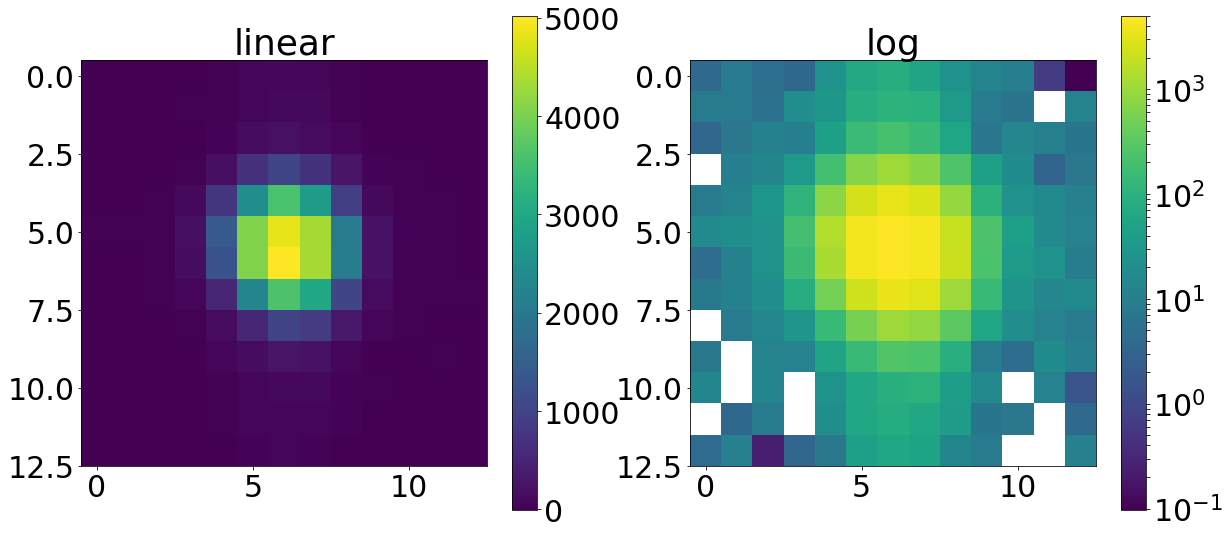

In [239]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img_zoom)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(test_img_zoom, norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [240]:
paramsp = lmfit.Parameters()
paramsp.add('z4p', 0.0)
paramsp.add('dxp', 0.0)
paramsp.add('dyp', 0.0)
paramsp.add('fp', 1.0)

In [241]:
def residual(pars,i):
    # unpack parameters:
    #  extract .value attribute for each parameter
    parvals = pars.valuesdict()
    z4p = parvals['z4p']
    dxp = parvals['dxp']
    dyp = parvals['dyp']
    fp = parvals['fp']
    test_img=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7296'+str(int(i))+'.npy')
    pos_of_max_flux=np.where(test_img==np.max(test_img))
    pos_of_max_flux=map(int,pos_of_max_flux)
    test_img_zoom=test_img[pos_of_max_flux[0]-6:pos_of_max_flux[0]+7,pos_of_max_flux[1]-6:pos_of_max_flux[1]+7]
    test_img_zoom_flux=np.sum(test_img_zoom)
    model = create_model_post0(i,dxp,dyp,z4p,fp)
    model=model*(test_img_zoom_flux/np.sum(model))
    print(np.sum(abs(model - test_img_zoom))/np.sum(test_img_zoom))    
    return (model - test_img_zoom)/1

In [242]:
fitter=lmfit.Minimizer(residual,paramsp,fcn_args=[i])

In [243]:
fitter.minimize()

0.448189
0.448189
0.448189
0.448184
0.447912
0.44849
0.447999
0.151645
0.151658
0.151643
0.151688
0.151702
0.0766662
0.0766722
0.0766711
0.0766602
0.0766908
0.0734464
0.0734468
0.0734494
0.0734468
0.0733652
0.0734803
0.0734808
0.0734834
0.0734807
0.0733991
0.0734723
0.0734723
0.0734723
0.0734756
0.0734787
0.0734791
0.0734817
0.0734791
0.0733974
0.0734781
0.0734784
0.0734788
0.0734814
0.0734788
0.0733971
0.0734778
0.0734782
0.0734786
0.0734813
0.0734786
0.0733969
0.0734777
0.0734781
0.0734807
0.073478
0.0733964
0.0734772
0.0734776


In [244]:
test_model0F=create_model_post0(i,fitter.values['dxp'],fitter.values['dyp'],fitter.values['z4p'],fitter.values['fp'])
test_model0F=test_model0F*(np.sum(test_img_zoom)/np.sum(test_model0F))

0.106396506196


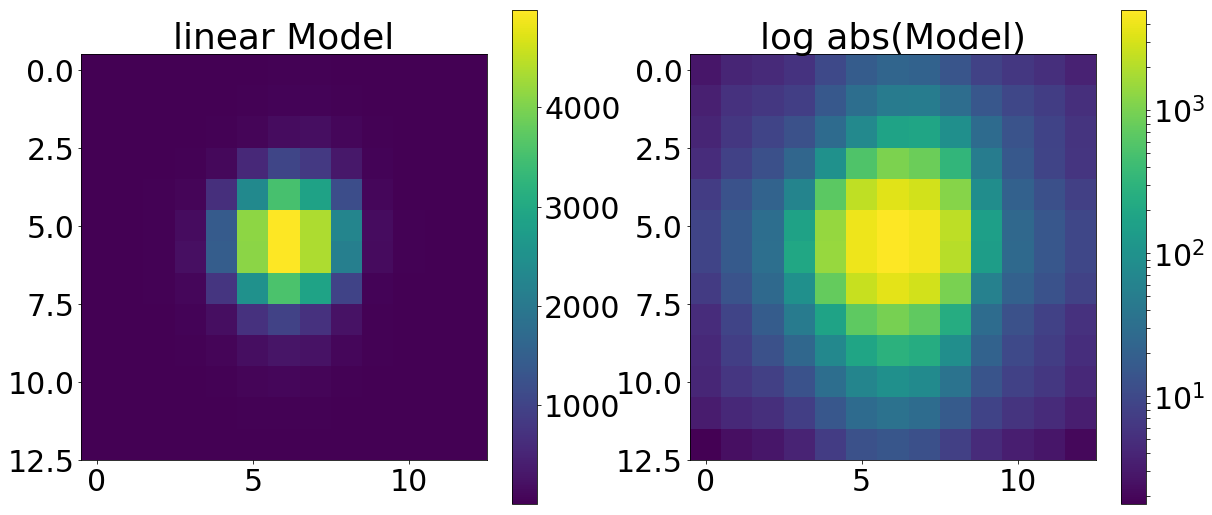

In [245]:
print(fitter.values['z4p'])
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_model0F)
plt.colorbar()
plt.title('linear Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.abs(test_model0F), norm=LogNorm())
plt.colorbar()
plt.title('log abs(Model)')
plt.grid(False)

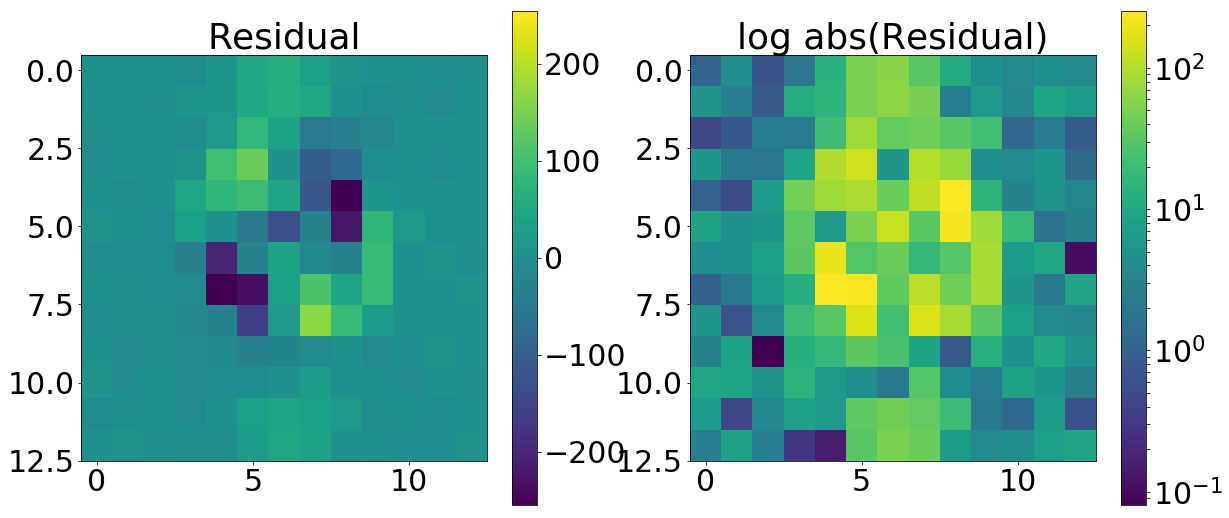

In [246]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img_zoom-test_model0F,vmin=-np.max(abs(test_img_zoom-test_model0F)),vmax=np.max(abs(test_img_zoom-test_model0F)))
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.abs(test_img_zoom-test_model0F), norm=LogNorm())
plt.colorbar()
plt.title('log abs(Residual)')
plt.grid(False)

In [247]:
print([fitter.values['dxp'],fitter.values['dyp'],fitter.values['z4p'],fitter.values['fp']])

[0.085043338818990871, -0.18716413380720998, 0.10639650619553646, 1.2746867706113854]


# Optimizer 

In [92]:
#__all__ = ['PupilFactory', 'Pupil']

class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale

class PupilFactory(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @params others
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.illumminatedFrac=illumminatedFrac
        self.pupilScale = pupilSize/npix
        self.slitFrac=slitFrac
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        

class PFSPupilFactory(PupilFactory):
    """!Pupil obscuration function factory for PFS 
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = (self.pupilSize/2)*self.illumminatedFrac

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        slitFrac = self.slitFrac 
        subaruSlit = slitFrac*subaruRadius
        # meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 
        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius


        
        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 2.62 / 1000 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98


        hscPlateScale = 380  
        thetaX = point.getX() * hscPlateScale 
        thetaY = point.getY() * hscPlateScale 

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        
        #No vignetting for the spectroscope 
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
            
        self._cutRay(pupil, (2,0), Angle(-np.pi),subaruSlit)    
        return pupil

In [103]:
### ZernikeFitter
class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    The centroid parameters are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,
                 jacobian=None,nonUniformEffect=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds (this is spectroscop)
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        """
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        # Note that this is a spectroscop and not an normal optical telescope,
        #so this is not real physical quantity
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        # Again, wavelength - this is a spectroscop
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        if nonUniformEffect is None:
            nonUniformEffect==False
        
        self.kwargs = kwargs
    
    def initParams(self, zmax=4, z4Init=None, centroidInit=None,hscFracInit=None,strutFracInit=None,
                   focalPlanePositionInit=None,fiber_rInit=None,flux_multInit=None,
                  slitFracInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves.
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscuraded by the camera ()
        @param strutFracInit        Fraction of the pupil obscuraded by the single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Size of the telescope in meters
        @param fiber_rInit          Factor that determines the size of the input fiber
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if centroidInit is None:
            params.add('dx', 0.0)
            params.add('dy', 0.0)
        else:
            params.add('dx', centroidInit[0])
            params.add('dy', centroidInit[1])   
            
        if hscFracInit is None:
            params.add('hscFrac', 0)
        else:
            params.add('hscFrac', hscFracInit)        

        if strutFracInit is None:
            params.add('strutFrac', 0)
        else:
            params.add('strutFrac', strutFracInit)             

        if focalPlanePositionInit is None:
            params.add('dxFocal', 0.0) 
            params.add('dyFocal', 0.0) 
        else:
            params.add('dxFocal', focalPlanePositionInit[0]) 
            params.add('dyFocal', focalPlanePositionInit[1]) 

        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
            
        if flux_multInit is None:
            params.add('flux_mult', 1)
        else:
            params.add('flux_mult', flux_multInit)    
                   
            
        if slitFracInit is None:
            params.add('slitFrac', 0)
        else:
            params.add('slitFrac', slitFracInit)     
            
        
        params.add('illumminatedFrac',0.96)        
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        Pupil_Image=PFSPupilFactory(3.3,756,
                                    1*np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],
                                  params['illumminatedFrac'.format(i)],params['slitFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=10240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params,pad_factor=1.5)

    def constructModelImage_PFS(self,params=None,shape=None,pixelScale=None,jacobian=None,nonUniformEffect=False):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)


        #This creates opticalpsf
        if nonUniformEffect==False:
            # 1 component
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
                
                
            optPsf=self._getOptPsf(v)
            optPsf = optPsf.shift(v['dx'], v['dy'])
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*v['fiber_r'])
            final = galsim.Convolve([gal, optPsf])
            modelImg = final.drawImage(
            nx = shape[0],
            ny = shape[1],
            wcs = wcs)
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg.array
        else:
            # 3 components
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
            
                        
            v['illumminatedFrac']=0.96
            optPsf1=self._getOptPsf(v)
            optPsf1 = optPsf1.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=0.986
            optPsf2=self._getOptPsf(v)
            optPsf2 = optPsf2.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=1
            optPsf3=self._getOptPsf(v)
            optPsf3 = optPsf3.shift(v['dx'], v['dy'])
            
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal1 = galsim.TopHat(flux=0.32, radius=(3/8)*(3/2)*v['fiber_r'])
            gal2 = galsim.TopHat(flux=0.334, radius=(3/8)*(3/2)*v['fiber_r'])
            gal3 = galsim.TopHat(flux=0.346, radius=(3/8)*(3/2)*v['fiber_r'])
            
            final1 = galsim.Convolve([gal1, optPsf1])
            final2 = galsim.Convolve([gal2, optPsf2])
            final3 = galsim.Convolve([gal3, optPsf3])
            
            modelImg1 = final1.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg2 = final2.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg3 = final3.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            
            modelImg=np.add(np.add(modelImg1.array,modelImg2.array),modelImg3.array)
            
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg

    
    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
       
# I think I do not need anything below
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

## First analysis

In [104]:
single_number=65
scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                str(single_number)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                str(single_number)+'.npy')

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
single_image_analysis.initParams(zmax=int(zOrder[1:len(zOrder)]))

In [105]:
chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/chainNov11_7310'
              +str(single_number)+'z22.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/flatchainNov11_7310'
          +str(single_number)+'z22.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/likeflatchainNov11_7310'+str(single_number)+'z22.npy')
chiflatchain=likeflatchain*(-2/(70**2-27))
flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]

#This creates flatchain which I think make a lot more sense; you can also define burn fraction

# Size of the pupil image 
npixInit=756
# Which side of focus we are on
side_of_focusInit=int(1)

burn_fraction=0.5
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()

    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))


medians=np.apply_along_axis(np.median, 0, flatchain)
medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

single_image_analysis.initParams(zmax=22)

#x=lowest_chi
x=medians_low



In [106]:
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['z12'].set(x[8])
single_image_analysis.params['z13'].set(x[9])
single_image_analysis.params['z14'].set(x[10])
single_image_analysis.params['z15'].set(x[11])
single_image_analysis.params['z16'].set(x[12])
single_image_analysis.params['z17'].set(x[13])
single_image_analysis.params['z18'].set(x[14])
single_image_analysis.params['z19'].set(x[15])      
single_image_analysis.params['z20'].set(x[16])
single_image_analysis.params['z21'].set(x[17]) 
single_image_analysis.params['z22'].set(x[18]) 
single_image_analysis.params['dx'].set(x[19])
single_image_analysis.params['dy'].set(x[20])
single_image_analysis.params['hscFrac'].set(x[21])
single_image_analysis.params['strutFrac'].set(x[22])
single_image_analysis.params['dxFocal'].set(x[23])
single_image_analysis.params['dyFocal'].set(x[24])
single_image_analysis.params['fiber_r'].set(x[25])
single_image_analysis.params['flux_mult'].set(x[26])
single_image_analysis.params['slitFrac'].set(x[27])                


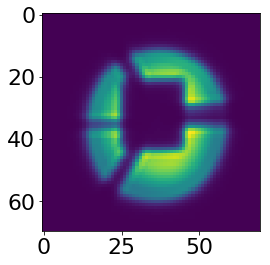

In [107]:
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
plt.imshow(best_img)

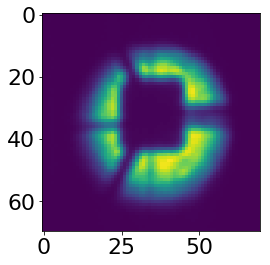

In [108]:
plt.imshow(scidata)

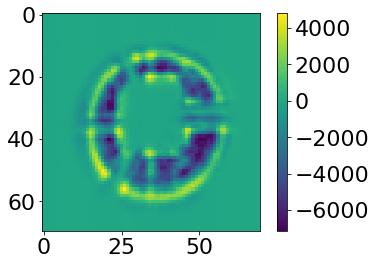

In [109]:
plt.imshow(best_img-scidata)
plt.colorbar()

In [110]:
np.sum((best_img-scidata)**2/vardata)/(70**2-27)

244.03042273753334

In [111]:
single_image_analysis.fit_LM()

Doing fit using Levenberg-Marquardt
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:243.057
chi**2/d.o.f. is:242.685
chi**2/d.o.f. is:242.685
chi**2/d.o.f. is:242.688
chi**2/d.o.f. is:242.688
chi**2/d.o.f. is:242.685
chi**2/d.o.f. is:242.689
chi**2/d.o.f. is:242.713
chi**2/d.o.f. is:242.687
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:242.682
chi**2/d.o.f. is:242.685
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:242.687
chi**2/d.o.f. is:242.687
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:242.683
chi**2/d.o.f. is:242.702
chi**2/d.o.f. is:242.69
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:242.679
chi**2/d.o.f. is:244.785
chi**2/d.o.f. is:242.695
chi**2/d.o.f. is:242.654
chi**2/d.o.f. is:242.55
chi**2/d.o.f. is:242.686
chi**2/d.o.f. is:244.191
chi**2/d.o.f. is:145.364
chi**2/d.o.f. is:144.846
chi**2/d.o.f. is:145.363
chi**2/d.o.f. is:145.341
chi**2/d.o.f. is:145.365
chi**2/d.o.f. is:145.367
chi**2/d.o.f. is

KeyboardInterrupt: 

In [407]:
res=single_image_analysis.result

In [408]:
x=[]
for key in res.params:
    x.append(res.params[key].value)

In [409]:
x

[12.916925728359853,
 -0.17744450986304422,
 -0.84178414838192217,
 -0.032357119926056742,
 -0.10587433095958387,
 0.017968547206969204,
 -0.19465558853389142,
 -0.10401410514847927,
 0.016905834172515146,
 -0.0055983047608566486,
 -0.046648834984869929,
 0.0063279150862113722,
 0.026882942889555204,
 0.079478533348967748,
 0.029623232899647522,
 -0.017909887603608871,
 -0.0078248552003136809,
 0.016973010879418975,
 0.2299485929840949,
 0.77436076149497324,
 0.19588990973871351,
 0.9226432491948281,
 0.17253926844551343,
 -0.07309099896518069,
 -0.13821347583163482,
 1.5305868127682276,
 0.97449154592555698,
 0.05100354947875517,
 0.95634466523755335]

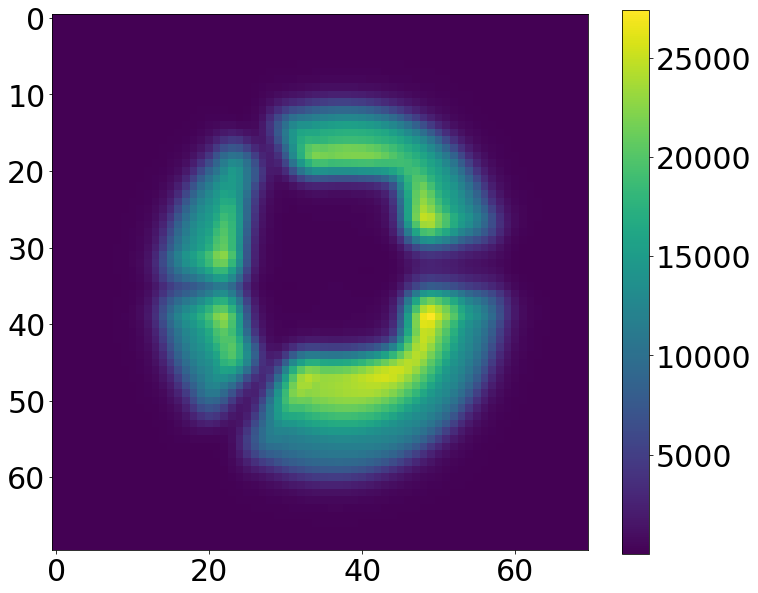

In [410]:
best_img=single_image_analysis.constructModelImage_PFS(res.params)      
plt.imshow(best_img)
plt.colorbar()

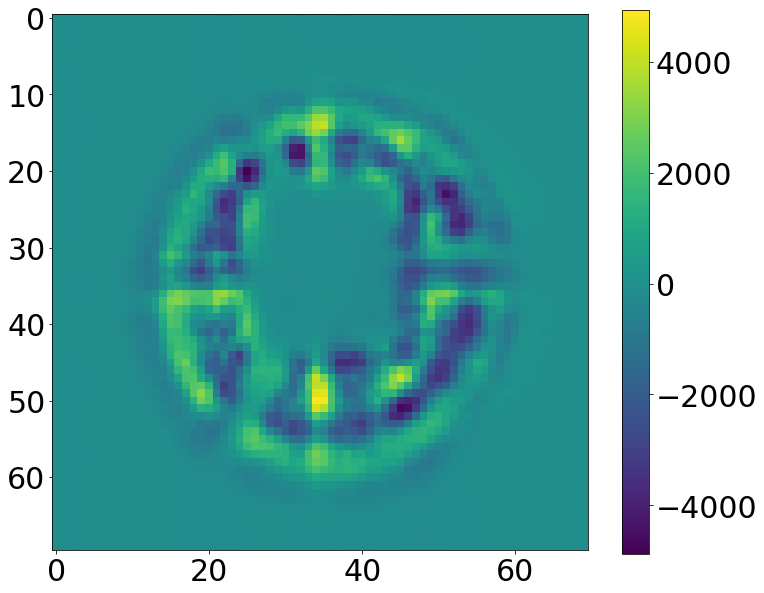

In [411]:
plt.imshow(best_img-scidata)
plt.colorbar()

In [412]:
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['z12'].set(x[8])
single_image_analysis.params['z13'].set(x[9])
single_image_analysis.params['z14'].set(x[10])
single_image_analysis.params['z15'].set(x[11])
single_image_analysis.params['z16'].set(x[12])
single_image_analysis.params['z17'].set(x[13])
single_image_analysis.params['z18'].set(x[14])
single_image_analysis.params['z19'].set(x[15])      
single_image_analysis.params['z20'].set(x[16])
single_image_analysis.params['z21'].set(x[17]) 
single_image_analysis.params['z22'].set(x[18]) 
single_image_analysis.params['dx'].set(x[19])
single_image_analysis.params['dy'].set(x[20])
single_image_analysis.params['hscFrac'].set(x[21])
single_image_analysis.params['strutFrac'].set(x[22])
single_image_analysis.params['dxFocal'].set(x[23])
single_image_analysis.params['dyFocal'].set(x[24])
single_image_analysis.params['fiber_r'].set(x[25])
single_image_analysis.params['flux_mult'].set(x[26])
single_image_analysis.params['slitFrac'].set(x[27])       

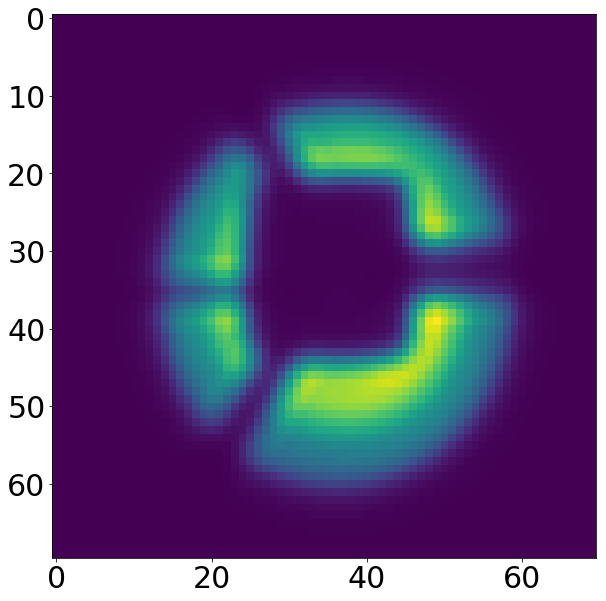

In [413]:
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
plt.imshow(best_img)

In [414]:
np.sum((best_img-scidata)**2/vardata)/(70**2-27)

125.06533449620358

In [415]:
single_image_analysis.fit_LM()

Doing fit using Levenberg-Marquardt
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.795
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.378
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.377
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.375
chi**2/d.o.f. is:124.383
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.377
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:124.387
chi**2/d.o.f. is:124.375
chi**2/d.o.f. is:124.375
chi**2/d.o.f. is:124.998
chi**2/d.o.f. is:124.381
chi**2/d.o.f. is:124.375
chi**2/d.o.f. is:124.388
chi**2/d.o.f. is:124.379
chi**2/d.o.f. is:124.378
chi**2/d.o.f. is:124.376
chi**2/d.o.f. is:125.788
chi**2/d.o.f. is:123.661
chi**2/d.o.f. is:123.876
chi**2/d.o.f. is:123.66
chi**2/d.o.f. is:123.654
chi**2/d.o.f. is:123.661
chi**2/d.o.f. is:123.662
chi**2/d.o.f. i

KeyboardInterrupt: 

Process PoolWorker-335:
KeyboardInterrupt
Process PoolWorker-341:
Process PoolWorker-340:
Process PoolWorker-342:
Process PoolWorker-339:
Process PoolWorker-345:
Process PoolWorker-336:
Process PoolWorker-343:
Process PoolWorker-346:
Process PoolWorker-333:
Process PoolWorker-334:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-338:
Process PoolWorker-337:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-344:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/nevencaplar/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/nevencaplar/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most re

## Creating scripts

In [ ]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

In [ ]:
# Create small test script
# Number of free parameters = 27
fiber=0
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TestCode22.sh','w') 

file.write("#!/bin/bash")
file.write("\n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH --ntasks-per-node=2 \n") 
file.write("#SBATCH -t 0:05:00 \n")
file.write("\n")
file.write("#1. zmax (4,11,22)\n") 
file.write("#2. Obs name (3617)\n") 
file.write("#3. Coordinates (e.g., x1626y1588 in early versions, single number in later)\n") 
file.write("#4. Name \n") 
file.write("\n")
for n in single_donut_objects_index[0:2]:
    file.write("python /home/ncaplar/Code/ZernikeLMNov11.py 22 7310 "+str(int(n))+" 0 &\n") 

In [182]:
%%capture
# This creates individual scripts - i made one script per each fiber

single_donut_objects_index_split=np.array_split(single_donut_objects_index,4)
for part in range(0,len(single_donut_objects_index_split)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/7310ScriptPerseusPart'+
                str(part)+'z22LM.sh','w') 
    
    file.write("#!/bin/bash")
    file.write("\n")
    file.write("#SBATCH -N 1 # node count \n")
    file.write("#SBATCH -N 1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH -t 23:59:00 \n")
    file.write("\n")
    file.write("#1. zmax (4 or 11)\n") 
    file.write("#2. Obs name (3617)\n") 
    file.write("#3. Coordinates (e.g., x1626y1588)\n") 
    file.write("#4. Name \n") 
    
    file.write("\n")
    for object in range(0,len(single_donut_objects_index_split[part])):
        file.write("python /home/ncaplar/Code/ZernikeLMNov11.py 22 7310 "+
                   str(int(single_donut_objects_index_split[part][object]))+" 0 & \n")
        file.write("P"+str(int(object)+1)+"=$! \n") 
        
    file.write("wait $P1 $P2 $P3 $P4 $P5 $P6 $P7 $P8 $P9 $P10 $P11 $P12 $P13 $P14 $P15 $P16 $P17 $P18 $P19 $P20 $P21 $P22 $P23 $P24 $P25")     
    file.close()  

In [153]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/7310ScriptToSubmitScriptsPerseusNov11'
                +'LM.sh','w')
file.write("#!/bin/bash")
file.write("\n")

for part in range(0,len(single_donut_objects_index_split)):
    file.write('sbatch /home/ncaplar/Scripts/7310ScriptPerseusPart'+
                str(part)+'z22LM.sh \n')

## Analyzing results

In [146]:
single_number=65
x_c=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/LM7310'+
            str(single_number)+str(single_number)+'.npy')

In [147]:
scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                str(single_number)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                str(single_number)+'.npy')

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
single_image_analysis.initParams(zmax=int(zOrder[1:len(zOrder)]))

In [148]:
chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/chainNov11_7310'
              +str(single_number)+'z22.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/flatchainNov11_7310'
          +str(single_number)+'z22.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/likeflatchainNov11_7310'+str(single_number)+'z22.npy')
chiflatchain=likeflatchain*(-2/(70**2-27))
flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]

#This creates flatchain which I think make a lot more sense; you can also define burn fraction

# Size of the pupil image 
npixInit=756
# Which side of focus we are on
side_of_focusInit=int(1)

burn_fraction=0.5
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()

    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))


medians=np.apply_along_axis(np.median, 0, flatchain)
medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

single_image_analysis.initParams(zmax=22)

#x=lowest_chi
x=medians_low



In [149]:
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['z12'].set(x[8])
single_image_analysis.params['z13'].set(x[9])
single_image_analysis.params['z14'].set(x[10])
single_image_analysis.params['z15'].set(x[11])
single_image_analysis.params['z16'].set(x[12])
single_image_analysis.params['z17'].set(x[13])
single_image_analysis.params['z18'].set(x[14])
single_image_analysis.params['z19'].set(x[15])      
single_image_analysis.params['z20'].set(x[16])
single_image_analysis.params['z21'].set(x[17]) 
single_image_analysis.params['z22'].set(x[18]) 
single_image_analysis.params['dx'].set(x[19])
single_image_analysis.params['dy'].set(x[20])
single_image_analysis.params['hscFrac'].set(x[21])
single_image_analysis.params['strutFrac'].set(x[22])
single_image_analysis.params['dxFocal'].set(x[23])
single_image_analysis.params['dyFocal'].set(x[24])
single_image_analysis.params['fiber_r'].set(x[25])
single_image_analysis.params['flux_mult'].set(x[26])
single_image_analysis.params['slitFrac'].set(x[27])                


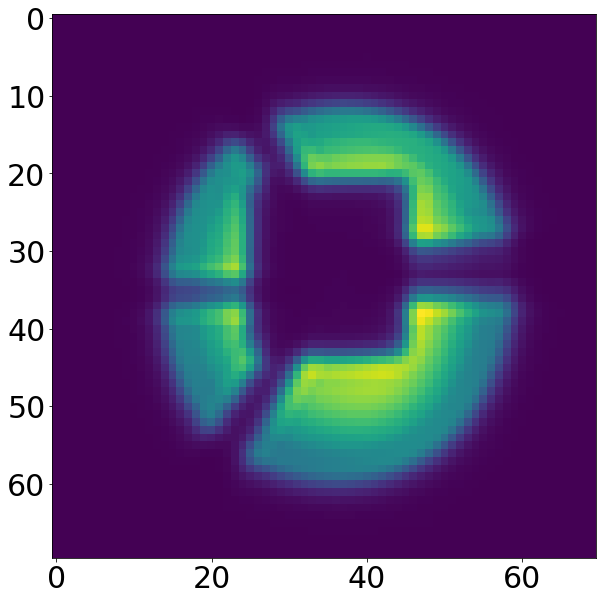

In [424]:
best_img_MC=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
plt.imshow(best_img_MC)

In [425]:
x=x_c
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['z12'].set(x[8])
single_image_analysis.params['z13'].set(x[9])
single_image_analysis.params['z14'].set(x[10])
single_image_analysis.params['z15'].set(x[11])
single_image_analysis.params['z16'].set(x[12])
single_image_analysis.params['z17'].set(x[13])
single_image_analysis.params['z18'].set(x[14])
single_image_analysis.params['z19'].set(x[15])      
single_image_analysis.params['z20'].set(x[16])
single_image_analysis.params['z21'].set(x[17]) 
single_image_analysis.params['z22'].set(x[18]) 
single_image_analysis.params['dx'].set(x[19])
single_image_analysis.params['dy'].set(x[20])
single_image_analysis.params['hscFrac'].set(x[21])
single_image_analysis.params['strutFrac'].set(x[22])
single_image_analysis.params['dxFocal'].set(x[23])
single_image_analysis.params['dyFocal'].set(x[24])
single_image_analysis.params['fiber_r'].set(x[25])
single_image_analysis.params['flux_mult'].set(x[26])
single_image_analysis.params['slitFrac'].set(x[27])     

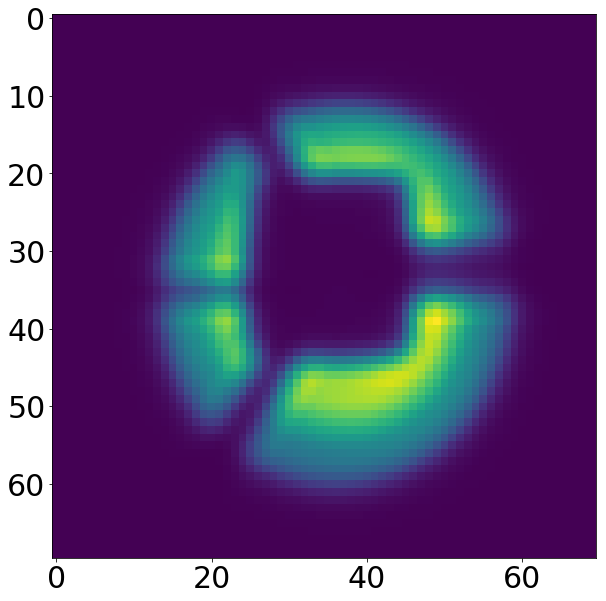

In [426]:
best_img_LM=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
plt.imshow(best_img_LM)

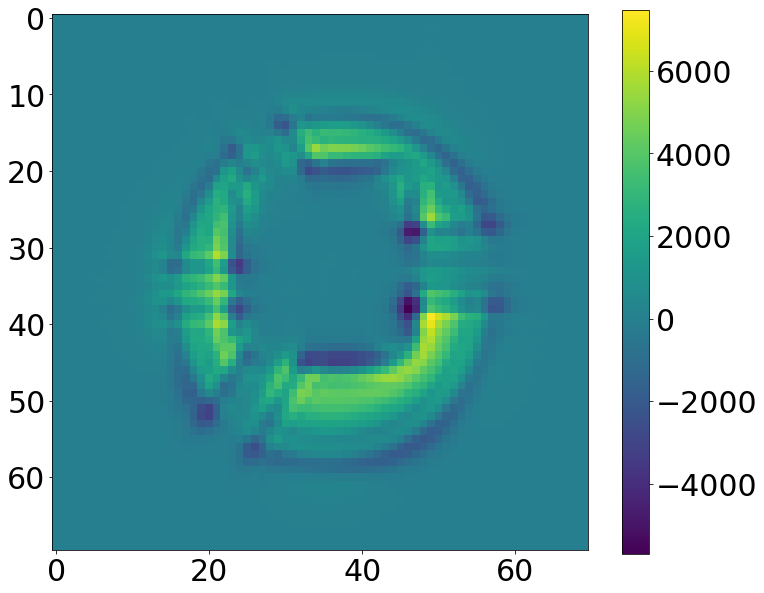

In [429]:
plt.imshow(best_img_LM-best_img_MC)
plt.colorbar()

### in focus result

In [17]:
#__all__ = ['PupilFactory', 'Pupil']

class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale

class PupilFactory(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @params others
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.illumminatedFrac=illumminatedFrac
        self.pupilScale = pupilSize/npix
        self.slitFrac=slitFrac
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        

class PFSPupilFactory(PupilFactory):
    """!Pupil obscuration function factory for PFS 
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = (self.pupilSize/2)*self.illumminatedFrac

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        slitFrac = self.slitFrac 
        subaruSlit = slitFrac*subaruRadius
        # meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 
        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius


        
        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 2.62 / 1000 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98


        hscPlateScale = 380  
        thetaX = point.getX() * hscPlateScale 
        thetaY = point.getY() * hscPlateScale 

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        
        #No vignetting for the spectroscope 
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
            
        self._cutRay(pupil, (2,0), Angle(-np.pi),subaruSlit)    
        return pupil

In [18]:
### ZernikeFitter
class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    The centroid parameters are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,
                 jacobian=None,nonUniformEffect=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds (this is spectroscop)
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        """
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        # Note that this is a spectroscop and not an normal optical telescope,
        #so this is not real physical quantity
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        # Again, wavelength - this is a spectroscop
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        if nonUniformEffect is None:
            nonUniformEffect==False
        
        self.kwargs = kwargs
    
    def initParams(self, zmax=4, z4Init=None, centroidInit=None,hscFracInit=None,strutFracInit=None,
                   focalPlanePositionInit=None,fiber_rInit=None,flux_multInit=None,
                  slitFracInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves.
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscuraded by the camera ()
        @param strutFracInit        Fraction of the pupil obscuraded by the single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Size of the telescope in meters
        @param fiber_rInit          Factor that determines the size of the input fiber
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if centroidInit is None:
            params.add('dx', 0.0)
            params.add('dy', 0.0)
        else:
            params.add('dx', centroidInit[0])
            params.add('dy', centroidInit[1])   
            
        if hscFracInit is None:
            params.add('hscFrac', 0)
        else:
            params.add('hscFrac', hscFracInit)        

        if strutFracInit is None:
            params.add('strutFrac', 0)
        else:
            params.add('strutFrac', strutFracInit)             

        if focalPlanePositionInit is None:
            params.add('dxFocal', 0.0) 
            params.add('dyFocal', 0.0) 
        else:
            params.add('dxFocal', focalPlanePositionInit[0]) 
            params.add('dyFocal', focalPlanePositionInit[1]) 

        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
            
        if flux_multInit is None:
            params.add('flux_mult', 1)
        else:
            params.add('flux_mult', flux_multInit)    
                   
            
        if slitFracInit is None:
            params.add('slitFrac', 0)
        else:
            params.add('slitFrac', slitFracInit)     
            
        
        params.add('illumminatedFrac',0.96)        
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        Pupil_Image=PFSPupilFactory(3.3,100,
                                    1*np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],
                                  params['illumminatedFrac'.format(i)],params['slitFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=10240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params,pad_factor=1.5)

    def constructModelImage_PFS(self,params=None,shape=None,pixelScale=None,jacobian=None,nonUniformEffect=False):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)


        #This creates opticalpsf
        if nonUniformEffect==False:
            # 1 component
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
                
                
            optPsf=self._getOptPsf(v)
            optPsf = optPsf.shift(v['dx'], v['dy'])
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*v['fiber_r'])
            final = galsim.Convolve([gal, optPsf])
            modelImg = final.drawImage(
            nx = shape[0],
            ny = shape[1],
            wcs = wcs)
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg.array
        else:
            # 3 components
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
            
                        
            v['illumminatedFrac']=0.96
            optPsf1=self._getOptPsf(v)
            optPsf1 = optPsf1.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=0.986
            optPsf2=self._getOptPsf(v)
            optPsf2 = optPsf2.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=1
            optPsf3=self._getOptPsf(v)
            optPsf3 = optPsf3.shift(v['dx'], v['dy'])
            
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal1 = galsim.TopHat(flux=0.32, radius=(3/8)*(3/2)*v['fiber_r'])
            gal2 = galsim.TopHat(flux=0.334, radius=(3/8)*(3/2)*v['fiber_r'])
            gal3 = galsim.TopHat(flux=0.346, radius=(3/8)*(3/2)*v['fiber_r'])
            
            final1 = galsim.Convolve([gal1, optPsf1])
            final2 = galsim.Convolve([gal2, optPsf2])
            final3 = galsim.Convolve([gal3, optPsf3])
            
            modelImg1 = final1.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg2 = final2.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg3 = final3.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            
            modelImg=np.add(np.add(modelImg1.array,modelImg2.array),modelImg3.array)
            
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg

    
    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
       
# I think I do not need anything below
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self,x):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

In [19]:
#Creating procedures for 0 case
    
def create_model_post0(single_number,dx,dy,z4,fp):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/chainNov11_7310'
                  +str(single_number)+'z22.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/flatchainNov11_7310'
              +str(single_number)+'z22.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/likeflatchainNov11_7310'+str(single_number)+'z22.npy')
    chiflatchain=likeflatchain*(-2/(70**2-27))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    
    # Size of the pupil image 
    npixInit=100
    # Which side of focus we are on
    side_of_focusInit=int(1)
    
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            

    medians=np.apply_along_axis(np.median, 0, flatchain)
    medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     
    
    scidata=np.ones((13,13))
    vardata=np.ones((13,13))
    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

    single_image_analysis.initParams(zmax=22)

    #x=lowest_chi
    x=medians_low
    single_image_analysis.params['z4'].set(z4)
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['z12'].set(x[8])
    single_image_analysis.params['z13'].set(x[9])
    single_image_analysis.params['z14'].set(x[10])
    single_image_analysis.params['z15'].set(x[11])
    single_image_analysis.params['z16'].set(x[12])
    single_image_analysis.params['z17'].set(x[13])
    single_image_analysis.params['z18'].set(x[14])
    single_image_analysis.params['z19'].set(x[15])      
    single_image_analysis.params['z20'].set(x[16])
    single_image_analysis.params['z21'].set(x[17]) 
    single_image_analysis.params['z22'].set(x[18]) 
    single_image_analysis.params['dx'].set(dx)
    single_image_analysis.params['dy'].set(dy)
    single_image_analysis.params['hscFrac'].set(x[21])
    single_image_analysis.params['strutFrac'].set(x[22])
    single_image_analysis.params['dxFocal'].set(x[23])
    single_image_analysis.params['dyFocal'].set(x[24])
    single_image_analysis.params['fiber_r'].set(fp)
    single_image_analysis.params['flux_mult'].set(x[26])


    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
    return best_img

In [36]:
def create_model_postLM0(single_number,dx,dy,z4,fp):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/chainNov11_7310'
                  +str(single_number)+'z22.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/flatchainNov11_7310'
              +str(single_number)+'z22.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/likeflatchainNov11_7310'+str(single_number)+'z22.npy')
    chiflatchain=likeflatchain*(-2/(70**2-27))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    
    # Size of the pupil image 
    npixInit=100
    # Which side of focus we are on
    side_of_focusInit=int(1)
    
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            

    medians=np.apply_along_axis(np.median, 0, flatchain)
    medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     
    
    scidata=np.ones((13,13))
    vardata=np.ones((13,13))
    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

    single_image_analysis.initParams(zmax=22)

    #x=lowest_chi
    x=x_c
    single_image_analysis.params['z4'].set(z4)
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['z12'].set(x[8])
    single_image_analysis.params['z13'].set(x[9])
    single_image_analysis.params['z14'].set(x[10])
    single_image_analysis.params['z15'].set(x[11])
    single_image_analysis.params['z16'].set(x[12])
    single_image_analysis.params['z17'].set(x[13])
    single_image_analysis.params['z18'].set(x[14])
    single_image_analysis.params['z19'].set(x[15])      
    single_image_analysis.params['z20'].set(x[16])
    single_image_analysis.params['z21'].set(x[17]) 
    single_image_analysis.params['z22'].set(x[18]) 
    single_image_analysis.params['dx'].set(dx)
    single_image_analysis.params['dy'].set(dy)
    single_image_analysis.params['hscFrac'].set(x[21])
    single_image_analysis.params['strutFrac'].set(x[22])
    single_image_analysis.params['dxFocal'].set(x[23])
    single_image_analysis.params['dyFocal'].set(x[24])
    single_image_analysis.params['fiber_r'].set(fp)
    single_image_analysis.params['flux_mult'].set(x[26])


    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
    return best_img

#### old

In [20]:
single_number=35
zOrder='z22'
scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                str(single_number)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                str(single_number)+'.npy')

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
single_image_analysis.initParams(zmax=int(zOrder[1:len(zOrder)]))

In [21]:
chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/chainNov11_7310'
              +str(single_number)+'z22.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/flatchainNov11_7310'
          +str(single_number)+'z22.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/likeflatchainNov11_7310'+str(single_number)+'z22.npy')
chiflatchain=likeflatchain*(-2/(70**2-27))
flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]

#This creates flatchain which I think make a lot more sense; you can also define burn fraction


burn_fraction=0.5
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()

    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))


medians=np.apply_along_axis(np.median, 0, flatchain)
medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

single_image_analysis=ZernikeFitter_PFS(scidata,vardata)

single_image_analysis.initParams(zmax=22)

#x=lowest_chi
x=medians_low



In [22]:

i=35
test_img=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7296'+str(int(i))+'.npy')
pos_of_max_flux=np.where(test_img==np.max(test_img))
pos_of_max_flux=map(int,pos_of_max_flux)
test_img_zoom=test_img[pos_of_max_flux[0]-6:pos_of_max_flux[0]+7,pos_of_max_flux[1]-6:pos_of_max_flux[1]+7]
test_img_zoom_flux=np.sum(test_img_zoom)

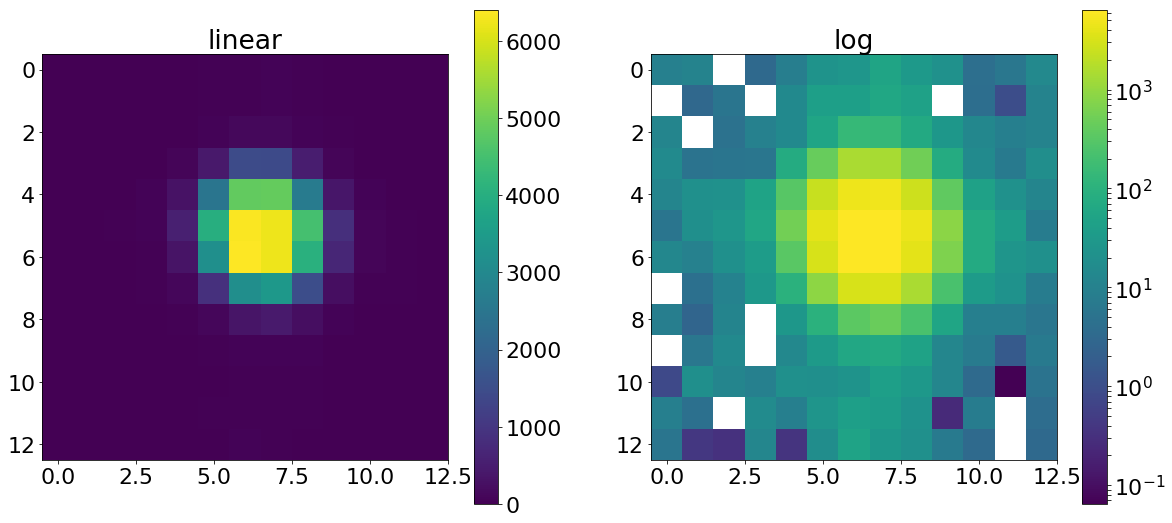

In [23]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img_zoom)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(test_img_zoom, norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [24]:
paramsp = lmfit.Parameters()
paramsp.add('z4p', 0.0)
paramsp.add('dxp', 0.0)
paramsp.add('dyp', 0.0)
paramsp.add('fp', 1.0)

In [25]:
def residual(pars,i):
    # unpack parameters:
    #  extract .value attribute for each parameter
    parvals = pars.valuesdict()
    z4p = parvals['z4p']
    dxp = parvals['dxp']
    dyp = parvals['dyp']
    fp = parvals['fp']
    test_img=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7296'+str(int(i))+'.npy')
    pos_of_max_flux=np.where(test_img==np.max(test_img))
    pos_of_max_flux=map(int,pos_of_max_flux)
    test_img_zoom=test_img[pos_of_max_flux[0]-6:pos_of_max_flux[0]+7,pos_of_max_flux[1]-6:pos_of_max_flux[1]+7]
    test_img_zoom_flux=np.sum(test_img_zoom)
    model = create_model_post0(i,dxp,dyp,z4p,fp)
    model=model*(test_img_zoom_flux/np.sum(model))
    print(np.sum(abs(model - test_img_zoom))/np.sum(test_img_zoom))    
    return (model - test_img_zoom)/1

In [26]:
fitter=lmfit.Minimizer(residual,paramsp,fcn_args=[i])

In [27]:
fitter.minimize()

0.769486
0.769486
0.769486
0.769463
0.769173
0.769806
0.769308
0.341409
0.341408
0.341375
0.341472
0.341541
0.102904
0.102906
0.10288
0.103002
0.103113
0.0696574
0.0696594
0.0696411
0.06967
0.0697311
0.0697581
0.0697601
0.0697426
0.0697704
0.0698348
0.0697382
0.0697401
0.0697228
0.0697503
0.0698155
0.0697337
0.0697356
0.0697185
0.0697459
0.0698113
0.0697326
0.0697346
0.0697174
0.0697448
0.0698102
0.0697329
0.0697348
0.0697176
0.069745
0.0698105
0.0697319
0.0697322
0.0697328


In [28]:
test_model0F=create_model_post0(i,fitter.values['dxp'],fitter.values['dyp'],fitter.values['z4p'],fitter.values['fp'])
test_model0F=test_model0F*(np.sum(test_img_zoom)/np.sum(test_model0F))

0.25863878179


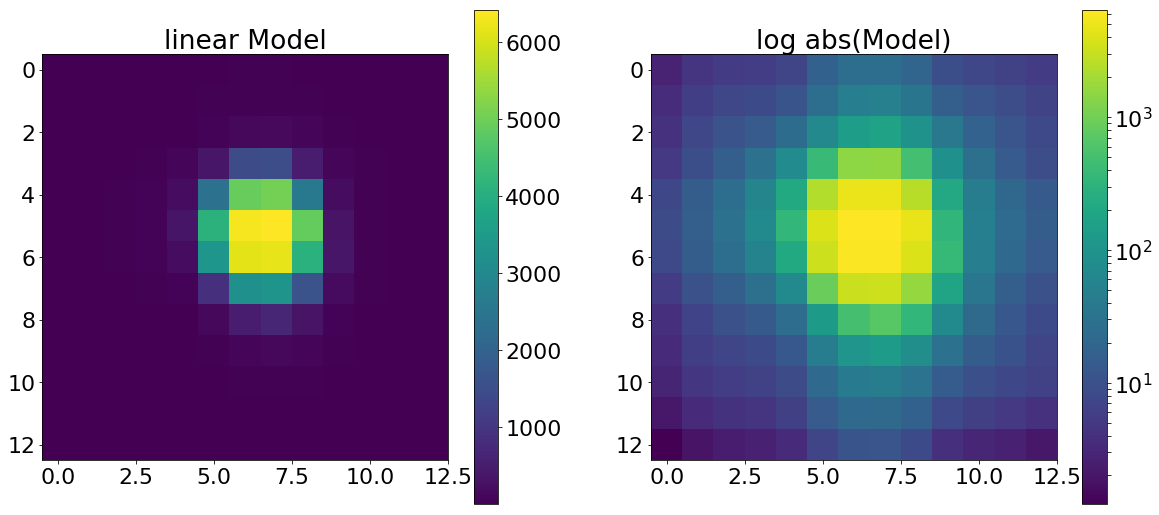

In [29]:
print(fitter.values['z4p'])
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_model0F)
plt.colorbar()
plt.title('linear Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.abs(test_model0F), norm=LogNorm())
plt.colorbar()
plt.title('log abs(Model)')
plt.grid(False)

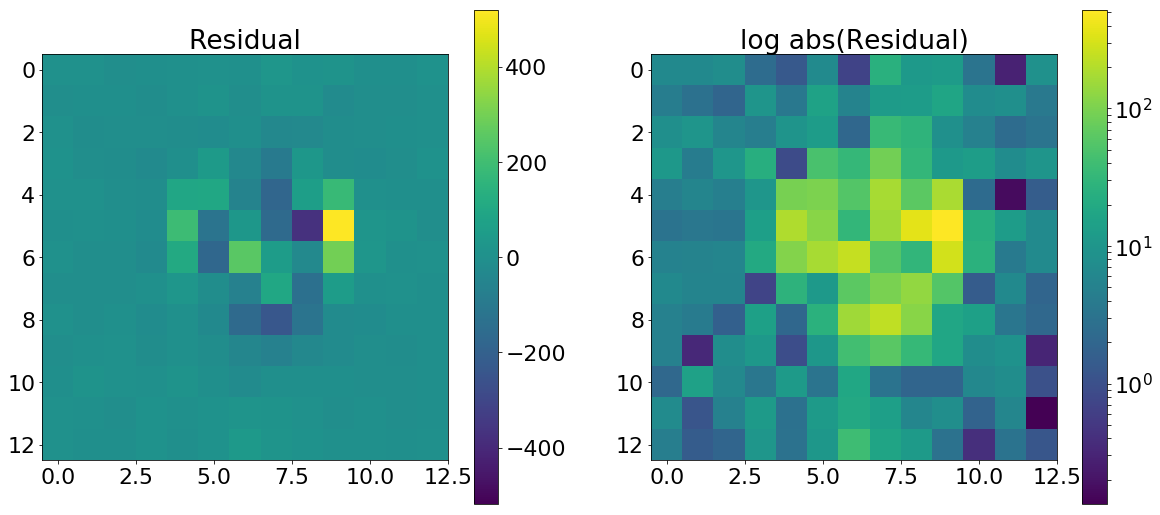

In [30]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img_zoom-test_model0F,vmin=-np.max(abs(test_img_zoom-test_model0F)),vmax=np.max(abs(test_img_zoom-test_model0F)))
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.abs(test_img_zoom-test_model0F), norm=LogNorm())
plt.colorbar()
plt.title('log abs(Residual)')
plt.grid(False)

In [31]:
print([fitter.values['dxp'],fitter.values['dyp'],fitter.values['z4p'],fitter.values['fp']])

[0.22998167792502641, -0.28471783620871605, 0.25863878178986127, 1.2357284645894722]


#### new 

In [81]:
single_number=65
x_c=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/LM7310'+
            str(single_number)+str(single_number)+'.npy')
x=x_c

In [82]:
x

array([ 12.88842061,  -0.17950139,  -0.8495083 ,  -0.02604802,
        -0.10529833,   0.01265954,  -0.20575388,  -0.10368322,
         0.0183027 ,  -0.00718631,  -0.05150195,   0.00576835,
         0.02585582,   0.07849725,   0.03572047,  -0.01491238,
        -0.00792939,   0.01713808,   0.22841591,   0.76558454,
         0.19014411,   0.92308748,   0.16993694,  -0.06989307,
        -0.13981682,   1.52458172,   0.97457824,   0.05100355,   0.95805895])

In [37]:
def residual(pars,i):
    # unpack parameters:
    #  extract .value attribute for each parameter
    parvals = pars.valuesdict()
    z4p = parvals['z4p']
    dxp = parvals['dxp']
    dyp = parvals['dyp']
    fp = parvals['fp']
    test_img=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7296'+str(int(i))+'.npy')
    pos_of_max_flux=np.where(test_img==np.max(test_img))
    pos_of_max_flux=map(int,pos_of_max_flux)
    test_img_zoom=test_img[pos_of_max_flux[0]-6:pos_of_max_flux[0]+7,pos_of_max_flux[1]-6:pos_of_max_flux[1]+7]
    test_img_zoom_flux=np.sum(test_img_zoom)
    model = create_model_postLM0(i,dxp,dyp,z4p,fp)
    model=model*(test_img_zoom_flux/np.sum(model))
    print(np.sum(abs(model - test_img_zoom))/np.sum(test_img_zoom))    
    return (model - test_img_zoom)/1

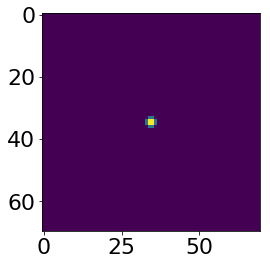

In [38]:
best_img_LM=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
plt.imshow(best_img_LM)

In [39]:
fitter=lmfit.Minimizer(residual,paramsp,fcn_args=[i])

In [40]:
fitter.minimize()

0.682651
0.682651
0.682651
0.682669
0.682234
0.683037
0.682589
0.2912
0.291217
0.291177
0.291264
0.291423
0.152393
0.152397
0.15239
0.152334
0.152443
0.136854
0.136857
0.136864
0.136851
0.136926
0.136667
0.136669
0.136677
0.136648
0.136739
0.136655
0.136658
0.136665
0.136637
0.136727
0.136665
0.136665
0.136661
0.136658
0.136656
0.136655
0.136658
0.136665
0.136637
0.136727
0.136655
0.136655
0.136655
0.136658
0.136665
0.136637
0.136727
0.136655


In [41]:
test_model0F=create_model_postLM0(i,fitter.values['dxp'],fitter.values['dyp'],fitter.values['z4p'],fitter.values['fp'])
test_model0F=test_model0F*(np.sum(test_img_zoom)/np.sum(test_model0F))

0.212186676101


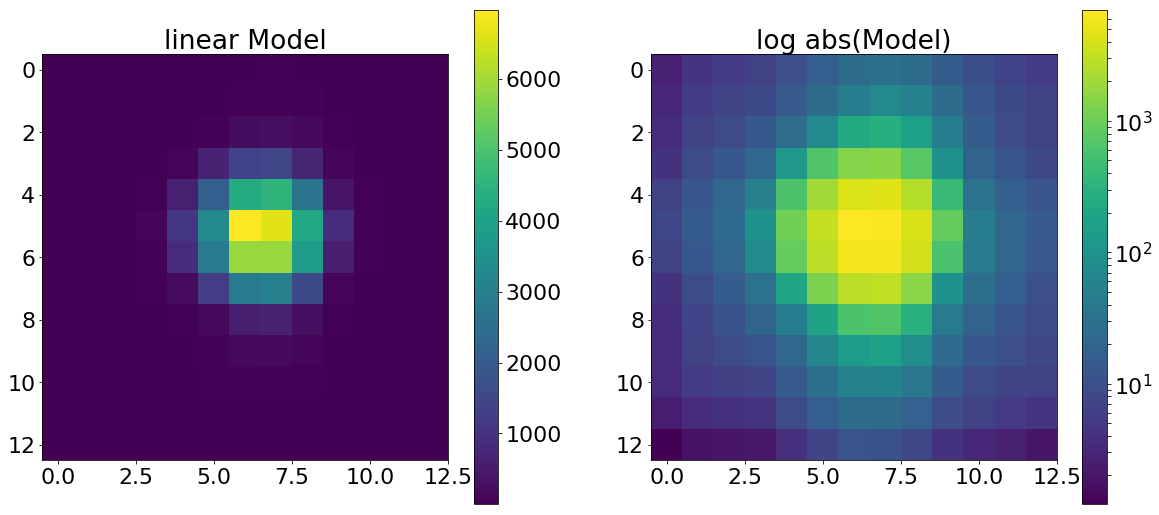

In [42]:
print(fitter.values['z4p'])
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_model0F)
plt.colorbar()
plt.title('linear Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.abs(test_model0F), norm=LogNorm())
plt.colorbar()
plt.title('log abs(Model)')
plt.grid(False)

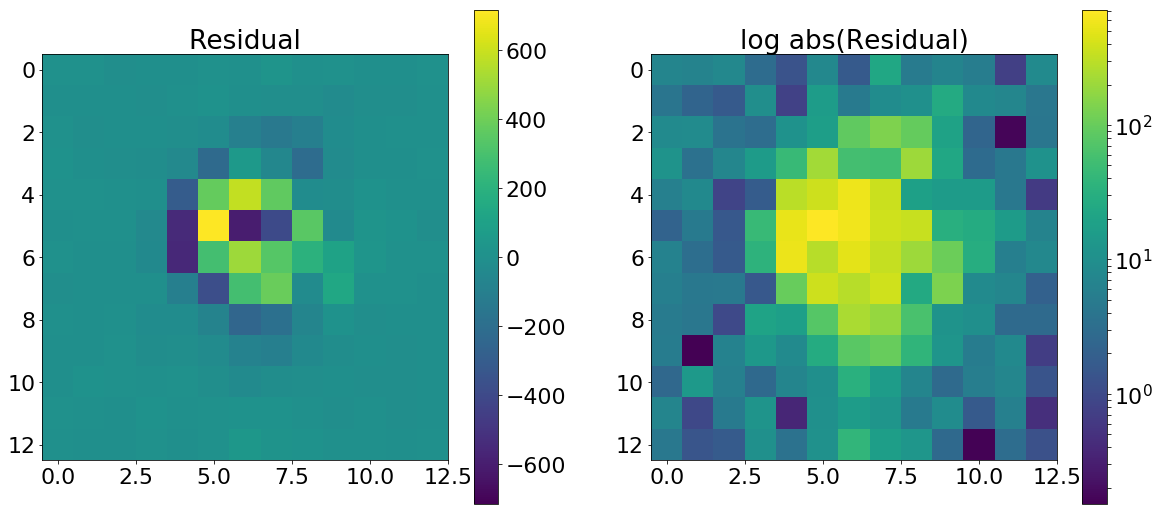

In [43]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img_zoom-test_model0F,vmin=-np.max(abs(test_img_zoom-test_model0F)),vmax=np.max(abs(test_img_zoom-test_model0F)))
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.abs(test_img_zoom-test_model0F), norm=LogNorm())
plt.colorbar()
plt.title('log abs(Residual)')
plt.grid(False)

In [44]:
print([fitter.values['dxp'],fitter.values['dyp'],fitter.values['z4p'],fitter.values['fp']])

[0.24945835053591237, -0.30907742714161496, 0.21218667610114778, 1.116524297546637]


# LM run

In [90]:
date='Nov11'
zOrder='z22'
import glob
import os
import string
os.chdir("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/"+date+"/")
list_of_chains=glob.glob("chain*"+zOrder+".npy")

In [91]:
single_donut_objects_index_analyzed=\
np.array((map(lambda x: int(string.split(string.split(x,'7310')[1],'z')[0]), list_of_chains)))

In [92]:
len(single_donut_objects_index_analyzed)

100

In [93]:
#Creating procedures 
    
def create_model_post(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                  '/chain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                      '/flatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                          '/likeflatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    
    x_c=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                  '/LM7310'+str(single_number)+str(single_number)+'.npy')
    
    chiflatchain=likeflatchain*(-2/(scidata.shape[0]**2-9))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    
    # Size of the pupil image 
    npixInit=756
    # Which side of focus we are on
    side_of_focusInit=int(1)
    
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            

    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
    single_image_analysis.initParams(zmax=int(zOrder[1:len(zOrder)]))

    #x=manual_medians
    #x=lowest_chi
    x=x_c
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['diam_sic'].set(3.3)  
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['z12'].set(x[8])
    single_image_analysis.params['z13'].set(x[9])
    single_image_analysis.params['z14'].set(x[10])
    single_image_analysis.params['z15'].set(x[11])
    single_image_analysis.params['z16'].set(x[12])
    single_image_analysis.params['z17'].set(x[13])
    single_image_analysis.params['z18'].set(x[14])
    single_image_analysis.params['z19'].set(x[15])      
    single_image_analysis.params['z20'].set(x[16])
    single_image_analysis.params['z21'].set(x[17]) 
    single_image_analysis.params['z22'].set(x[18]) 
    single_image_analysis.params['dx'].set(x[19])
    single_image_analysis.params['dy'].set(x[20])
    single_image_analysis.params['hscFrac'].set(x[21])
    single_image_analysis.params['strutFrac'].set(x[22])
    single_image_analysis.params['dxFocal'].set(x[23])
    single_image_analysis.params['dyFocal'].set(x[24])
    single_image_analysis.params['fiber_r'].set(x[25])
    single_image_analysis.params['flux_mult'].set(x[26])
    single_image_analysis.params['slitFrac'].set(x[27]) 
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)  

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Model/'+str(single_number),best_img)
    
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['diam_sic'].set(3.3)  
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['z12'].set(x[8])
    single_image_analysis.params['z13'].set(x[9])
    single_image_analysis.params['z14'].set(x[10])
    single_image_analysis.params['z15'].set(x[11])
    single_image_analysis.params['z16'].set(x[12])
    single_image_analysis.params['z17'].set(x[13])
    single_image_analysis.params['z18'].set(x[14])
    single_image_analysis.params['z19'].set(x[15])      
    single_image_analysis.params['z20'].set(x[16])
    single_image_analysis.params['z21'].set(x[17]) 
    single_image_analysis.params['z22'].set(x[18]) 
    single_image_analysis.params['dx'].set(x[19])
    single_image_analysis.params['dy'].set(x[20])
    single_image_analysis.params['hscFrac'].set(x[21])
    single_image_analysis.params['strutFrac'].set(x[22])
    single_image_analysis.params['dxFocal'].set(x[23])
    single_image_analysis.params['dyFocal'].set(x[24])
    single_image_analysis.params['fiber_r'].set(x[25])
    single_image_analysis.params['flux_mult'].set(x[26])
    single_image_analysis.params['slitFrac'].set(x[27]) 
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)  

    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)    
#    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Model0/'+str(single_number),best_img)
    
    
    Pupil_data=PFSPupilFactory(single_image_analysis.params['diam_sic'.format(i)].value,single_image_analysis.params['npix'.format(i)],
                               single_image_analysis.params['side_of_focus'.format(i)]*np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value,0.96,
                               single_image_analysis.params['slitFrac'.format(i)])
    point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
    pupil=Pupil_data.getPupil(point)
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Pupil/'+str(single_number),pupil.illuminated)


def create_residual_post(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'/Model/'+str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Residual/'+str(single_number),scidata-modeldata)
    np.save('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Chi/'+str(single_number),((scidata-modeldata)**2)/vardata) 
    
def create_maxvalue(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(single_number)+'.npy')
    maxvalue=np.max(scidata)*1.01
    np.save('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/maxvalue'+str(single_number),maxvalue)    
    

In [94]:
%%capture
map(create_maxvalue, single_donut_objects_index_analyzed)

In [190]:
%%capture
import multiprocessing
pool = multiprocessing.Pool()
pool.map(create_model_post, single_donut_objects_index_analyzed)
pool.close

In [191]:
%%capture
map(create_residual_post,single_donut_objects_index_analyzed)

#### Display images

In [95]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

if len(single_donut_objects_index_analyzed)==len(single_donut_objects_index):
    single_donut_objects_index_analyzed=single_donut_objects_index


In [194]:
def show_images(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0007310, "+str(save), fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
 #        if image.ndim == 2:
 #            plt.gray()
        if save=='Residuals, rescaled':
            plt.imshow(image)
        else:
            if save=='Chi':
                plt.imshow(image)
            else:
                plt.imshow(np.abs(image),vmax=maxvalue/maxValueDivision)
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Summary/'+str(save))
      

In [195]:
def show_images_log(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0007310, "+str(save)+' /Log scaling', fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
 #        if image.ndim == 2:
 #            plt.gray()
        plt.imshow(np.abs(image),vmin=1,vmax=maxvalue/maxValueDivision, norm=LogNorm())
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Summary/'+str(save)+' Log')
      

In [196]:
list_of_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_images.append(np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(int(i))+'.npy'))

list_of_maxvalues=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_maxvalues.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/maxvalue'+str(int(i))+'.npy'))        

#list_of_titles=[]
#for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended_full)):
#    for j in range (0,len(single_number_for_single_pos_single_donut_split_by_y_appended_full[i])):
#        list_of_titles.append(str((int(single_number_for_single_pos_single_donut_split_by_y_appended_full[i][j][3]),
#                           int(4175-single_number_for_single_pos_single_donut_split_by_y_appended_full[i][j][4]))))
        
list_of_titles=[]
for i in list(single_donut_objects_index_analyzed):
    single_number_for_single_pos_full_analyzed_row=\
    single_number_for_single_pos_full[single_number_for_single_pos_full[:,0]==i]
    list_of_titles.append(str((int(single_number_for_single_pos_full_analyzed_row[0][3]),
                           int(4175-single_number_for_single_pos_full_analyzed_row[0][4]))))    

In [197]:
list_of_model_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_model_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Model/'+str(int(i))+'.npy'))        
    
        
list_of_residual_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_residual_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Residual/'+str(int(i))+'.npy'))     
    
                
list_of_pupil_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_pupil_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Pupil/'+str(int(i))+'.npy'))         
    
list_of_model0_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_model0_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Model0/'+str(int(i))+'.npy'))      

list_of_chi_images=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_chi_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/'+date+'/'+zOrder+'LM/Chi/'+str(int(i))+'.npy'))      
    
list_of_maxvalues_pupil=[]
for i in list(single_donut_objects_index_analyzed):
    list_of_maxvalues_pupil.append(2)  

In [198]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [199]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [200]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [201]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [202]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [203]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [204]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, rescaled',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [205]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_pupil_images[0:how_many_images],
            int(how_many_images/10),save='Pupils',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues_pupil[0:how_many_images],maxValueDivision=2)

In [206]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_chi_images[0:how_many_images],
            int(how_many_images/10),save='Chi',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues_pupil[0:how_many_images],maxValueDivision=1)

### Parameter dependance

In [96]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

if len(single_donut_objects_index_analyzed)==len(single_donut_objects_index):
    single_donut_objects_index_analyzed=single_donut_objects_index

In [110]:
def lowest_chi_par(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                  '/chain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                      '/flatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                          '/likeflatchain'+date+'_7310'+str(single_number)+zOrder+'.npy')
    
    chiflatchain=likeflatchain*(-2/(70**2-28))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/var7310'+
                    str(single_number)+'.npy')
    
    x_c=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+
                  '/LM7310'+str(single_number)+str(single_number)+'.npy')
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            
    medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    # Possible problem - likelihood has different shape than chain!    
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]  
    lowest_chi=x_c[0:28]
    x=x_c[0:28]
    
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['diam_sic'].set(3.3)  
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['z12'].set(x[8])
    single_image_analysis.params['z13'].set(x[9])
    single_image_analysis.params['z14'].set(x[10])
    single_image_analysis.params['z15'].set(x[11])
    single_image_analysis.params['z16'].set(x[12])
    single_image_analysis.params['z17'].set(x[13])
    single_image_analysis.params['z18'].set(x[14])
    single_image_analysis.params['z19'].set(x[15])      
    single_image_analysis.params['z20'].set(x[16])
    single_image_analysis.params['z21'].set(x[17]) 
    single_image_analysis.params['z22'].set(x[18]) 
    single_image_analysis.params['dx'].set(x[19])
    single_image_analysis.params['dy'].set(x[20])
    single_image_analysis.params['hscFrac'].set(x[21])
    single_image_analysis.params['strutFrac'].set(x[22])
    single_image_analysis.params['dxFocal'].set(x[23])
    single_image_analysis.params['dyFocal'].set(x[24])
    single_image_analysis.params['fiber_r'].set(x[25])
    single_image_analysis.params['flux_mult'].set(x[26])
    single_image_analysis.params['slitFrac'].set(x[27]) 
    single_image_analysis.params['npix'].set(npixInit)
    single_image_analysis.params['side_of_focus'].set(side_of_focusInit)  
    best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)
    best_img=(np.sum(scidata)/np.sum(best_img))*best_img
    
    low_chi=np.sum((best_img-scidata)**2/vardata)/(70**2-28)
    
    
    
    #low_chi=np.min(-likeflatchain)*(2)/(70**2-28)
    maxchi2=np.sum(scidata**2/vardata)/(70**2-28)
    
    #help_array=np.append(np.append(lowest_chi,low_chi),maxchi2)
    help_array=np.append(np.append(lowest_chi,low_chi),maxchi2)
    return np.append(help_array,single_number_for_single_pos_full[single_number_for_single_pos_full[:,0]==single_number])
    

In [111]:
lowest_chi_pos=[]
for i in single_donut_objects_index_analyzed:
    lowest_chi_pos=np.append(lowest_chi_pos,lowest_chi_par(int(i)))

lowest_chi_pos=lowest_chi_pos.reshape(len(single_donut_objects_index_analyzed),int(len(lowest_chi_pos)/len(single_donut_objects_index_analyzed)))
#Switch y axis from numpy to chip counting
lowest_chi_pos[:,34]=4175-lowest_chi_pos[:,34]

np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/'+date+'/lowest_chi_posLM',lowest_chi_pos)

In [112]:
descriptions=['0_z4','1_z5','2_z6','3_z7','4_z8','5_z9','6_z10','7_z11','8_z12','9_z13','10_z14','11_z15','12_z16',
              '13_z17','14_z18','15_z19','16_z20','17_z21','18_z22','19_dx','20_dy','21_hscFrac','22_strutFrac',
              '23_dxFocal','24_dyFocal','25_rfiber','26_fluxmult','27_slitFrac','28_chi**2 per d.o.f.','29_maxchi**2 per d.o.f.',
              '30_unique index','31_fiber', '32_spot index', '33_xpos', '34_ypos']

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

for i in range(0,len(descriptions)):

    N = len(single_donut_objects_index_analyzed)
    x = lowest_chi_pos[:,33]
    y = lowest_chi_pos[:,34]
    colors = lowest_chi_pos[:,i]
    area = np.pi * (15 * 1)**2  # 0 to 15 point radii

    if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])[0] == True:
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
            abs_max_colors=max(np.abs(colors))
            max_colors=0.5
            min_colors=-0.5
        else:
            abs_max_colors=max(np.abs(colors))
            max_colors=0.1
            min_colors=-0.1
    else:   
        max_colors=max(colors)
        min_colors=min(colors)

    plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
    plt.ylim(0,4416)
    plt.xlim(0,4294)
    plt.xlabel('x position on chip')
    plt.ylabel('y position on chip')
    plt.title(descriptions[i].split("_")[1])


    plt.colorbar()
    #plt.show()
    plt.savefig('/Users/nevencaplar/Documents/PFS/Images/'+date+'/z22LM/Summary/'+str(descriptions[i]))
    plt.clf()    

# Nov 12

## Testing code

In [38]:
###
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=12000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
import time
import sys

import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib

matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore')

__all__ = ['PupilFactory', 'Pupil']


#__all__ = ['PupilFactory', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale

class PupilFactory(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @params others
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.illumminatedFrac=illumminatedFrac
        self.pupilScale = pupilSize/npix
        self.slitFrac=slitFrac        
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        



class PFSPupilFactory(PupilFactory):
    """!Pupil obscuration function factory for PFS 
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac,illumminatedFrac,slitFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = (self.pupilSize/2)*self.illumminatedFrac

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        slitFrac = self.slitFrac 
        subaruSlit = slitFrac*subaruRadius
        # meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 
        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 2.62 / 1000 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98


        hscPlateScale = 380  
        thetaX = point.getX() * hscPlateScale 
        thetaY = point.getY() * hscPlateScale 

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        
        #No vignetting for the spectroscope 
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
            
        self._cutRay(pupil, (2,0), Angle(-np.pi),subaruSlit)      
        return pupil
    

class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    The centroid parameters are at the moment free are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method, which sets initial parameter guesses and ranges.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,
                 jacobian=None,nonUniformEffect=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds (this is spectroscop)
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        """
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        # Note that this is a spectroscop and not an normal optical telescope,
        #so this is not real physical quantity
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        # Again, wavelength - this is a spectroscop
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        if nonUniformEffect is None:
            nonUniformEffect==False
        
        self.kwargs = kwargs
    
    def initParams(self, zmax=4, z4Init=None, centroidInit=None,hscFracInit=None,strutFracInit=None,
                   focalPlanePositionInit=None,diam_sicInit=None,fiber_rInit=None,flux_multInit=None,
                   npixInit=None,side_of_focusInit=None,slitFracInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves.
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscuraded by the camera ()
        @param strutFracInit        Fraction of the pupil obscuraded by the single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Size of the telescope in meters
        @param fiber_rInit          Factor that determines the size of the input fiber
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        if z4Init is None:
            params.add('z4', 0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if centroidInit is None:
            params.add('dx', 0.0)
            params.add('dy', 0.0)
        else:
            params.add('dx', centroidInit[0])
            params.add('dy', centroidInit[1])   
            
        if hscFracInit is None:
            params.add('hscFrac', 0)
        else:
            params.add('hscFrac', hscFracInit)        

        if strutFracInit is None:
            params.add('strutFrac', 0)
        else:
            params.add('strutFrac', strutFracInit)             

        if focalPlanePositionInit is None:
            params.add('dxFocal', 0.0) 
            params.add('dyFocal', 0.0) 
        else:
            params.add('dxFocal', focalPlanePositionInit[0]) 
            params.add('dyFocal', focalPlanePositionInit[1]) 
            
        if diam_sicInit is None:
            params.add('diam_sic', 3.3)
        else:
            params.add('diam_sic', diam_sicInit)   
            
        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)   
            
        if flux_multInit is None:
            params.add('flux_mult', 1)
        else:
            params.add('flux_mult', flux_multInit)    
        
        if npixInit is None:
            params.add('npix', 512)
        else:
            params.add('npix', npixInit)    
            
        if side_of_focusInit is None:
            params.add('side_of_focus', 1)
        else:
            params.add('side_of_focus', side_of_focusInit)      
            
        if slitFracInit is None:
            params.add('slitFrac', 0)
        else:
            params.add('slitFrac', slitFracInit)             
                                    
        params.add('illumminatedFrac',0.96)        
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        Pupil_Image=PFSPupilFactory(params['diam_sic'.format(i)],params['npix'.format(i)],
                                           params['side_of_focus'.format(i)]*np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],
                                  params['illumminatedFrac'.format(i)],params['slitFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=10240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params)

    def constructModelImage_PFS(self,params=None,shape=None,pixelScale=None,jacobian=None,nonUniformEffect=False):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)


        #This creates opticalpsf
        if nonUniformEffect==False:
            # 1 component
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
                
                
            optPsf=self._getOptPsf(v)
            optPsf = optPsf.shift(v['dx'], v['dy'])
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*v['fiber_r'])
            final = galsim.Convolve([gal, optPsf])
            modelImg = final.drawImage(
            nx = shape[0],
            ny = shape[1],
            wcs = wcs)
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg.array
        else:
            # 3 components
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
            
                        
            v['illumminatedFrac']=0.96
            optPsf1=self._getOptPsf(v)
            optPsf1 = optPsf1.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=0.986
            optPsf2=self._getOptPsf(v)
            optPsf2 = optPsf2.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=1
            optPsf3=self._getOptPsf(v)
            optPsf3 = optPsf3.shift(v['dx'], v['dy'])
            
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal1 = galsim.TopHat(flux=0.32, radius=(3/8)*(3/2)*v['fiber_r'])
            gal2 = galsim.TopHat(flux=0.334, radius=(3/8)*(3/2)*v['fiber_r'])
            gal3 = galsim.TopHat(flux=0.346, radius=(3/8)*(3/2)*v['fiber_r'])
            
            final1 = galsim.Convolve([gal1, optPsf1])
            final2 = galsim.Convolve([gal2, optPsf2])
            final3 = galsim.Convolve([gal3, optPsf3])
            
            modelImg1 = final1.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg2 = final2.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg3 = final3.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            
            modelImg=np.add(np.add(modelImg1.array,modelImg2.array),modelImg3.array)
            
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg

    
    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
    
 
    
    # I think I do not need anything below
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 
 
 
def create_par_Init_keep_values(val1,val2,val_len):
    return np.insert(np.random.normal(val1,val2,val_len-1),0,val1)    
    
def create_parInit(zmax,fixed_z4_diam_value=None,walkers_mult=None,previous_values=None,previous_values_errors=None,restart=None):
    if fixed_z4_diam_value is None:
        fixed_z4_diam_value=False
    if restart is None:
        restart=0        
    if walkers_mult is None:
        walkers_mult=10    
    if fixed_z4_diam_value==False:
        if zmax==4:
            number_of_par=9+1+1
            nwalkers=number_of_par*walkers_mult
            parz4Init=np.random.randint(low=0, high=1000, size=nwalkers)/100
            pardxInit=np.random.randint(low=-1000, high=1000, size=nwalkers)/100
            pardyInit=np.random.randint(low=-1000, high=1000, size=nwalkers)/100
            parhscFracInit=np.random.randint(low=60, high=120, size=nwalkers)/100
            parstrutFracInit=np.random.randint(low=5, high=30, size=nwalkers)/100
            pardxFocalInit=np.random.randint(low=-100, high=100, size=nwalkers)/100
            pardyFocalInit=np.random.randint(low=-100, high=100, size=nwalkers)/100
            pardiamsicInit=np.random.randint(low=200, high=450, size=nwalkers)/100
            parfiberrInit=np.random.randint(low=100, high=150, size=nwalkers)/100
            parfluxmultInit=np.random.randint(low=80, high=120, size=nwalkers)/100
            parslitFracInit=np.random.randint(low=0, high=20, size=nwalkers)/100
            par_together=np.column_stack((parz4Init,
                                          pardxInit,pardyInit,
                                          parhscFracInit,parstrutFracInit,
                                          pardxFocalInit,pardyFocalInit,
                                          pardiamsicInit,parfiberrInit,parfluxmultInit,parslitFracInit))
            parInit=par_together.reshape(nwalkers,number_of_par)
            return parInit

        if zmax==11:
            number_of_par=9+7+1+1
            nwalkers=number_of_par*walkers_mult
            parz4Init=np.random.normal(previous_values[0],previous_values_errors[0],nwalkers)
            parz5Init=np.random.normal(0,0.1,nwalkers)
            parz6Init=np.random.normal(0,0.1,nwalkers)
            parz7Init=np.random.normal(0,0.1,nwalkers)
            parz8Init=np.random.normal(0,0.1,nwalkers)
            parz9Init=np.random.normal(0,0.1,nwalkers)
            parz10Init=np.random.normal(0,0.1,nwalkers)
            parz11Init=np.random.normal(0,0.1,nwalkers)
            pardxInit=np.random.normal(previous_values[1],previous_values_errors[1],nwalkers)
            pardyInit=np.random.normal(previous_values[2],previous_values_errors[2],nwalkers)
            parhscFracInit=np.random.normal(previous_values[3],previous_values_errors[3],nwalkers)
            parstrutFracInit=np.random.normal(previous_values[4],previous_values_errors[4],nwalkers)
            pardxFocalInit=np.random.normal(previous_values[5],previous_values_errors[5],nwalkers)
            pardyFocalInit=np.random.normal(previous_values[6],previous_values_errors[6],nwalkers)
            pardiamsicInit=np.random.normal(previous_values[7],previous_values_errors[7],nwalkers)
            parfiberrInit=np.random.normal(previous_values[8],previous_values_errors[8],nwalkers)
            parfluxmultInit=np.random.normal(previous_values[9],previous_values_errors[9],nwalkers)
            parslitFracInit=np.random.normal(previous_values[10],previous_values_errors[10],nwalkers)       
            par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                                          pardxInit,pardyInit,
                                          parhscFracInit,parstrutFracInit,
                                          pardxFocalInit,pardyFocalInit,
                                          pardiamsicInit,parfiberrInit,parfluxmultInit,parslitFracInit))
            parInit=par_together.reshape(nwalkers,number_of_par)    
            return parInit
        
        if zmax==22:
            number_of_par=9+7+11+1+1
            nwalkers=number_of_par*walkers_mult
            parz4Init=np.random.normal(previous_values[0],previous_values_errors[0],nwalkers)
            parz5Init=np.random.normal(previous_values[1],previous_values_errors[1],nwalkers)
            parz6Init=np.random.normal(previous_values[2],previous_values_errors[2],nwalkers)
            parz7Init=np.random.normal(previous_values[3],previous_values_errors[3],nwalkers)
            parz8Init=np.random.normal(previous_values[4],previous_values_errors[4],nwalkers)
            parz9Init=np.random.normal(previous_values[5],previous_values_errors[5],nwalkers)
            parz10Init=np.random.normal(previous_values[6],previous_values_errors[6],nwalkers)
            parz11Init=np.random.normal(previous_values[7],previous_values_errors[7],nwalkers)
            parz12Init=np.random.normal(0,0.1,nwalkers)
            parz13Init=np.random.normal(0,0.1,nwalkers)
            parz14Init=np.random.normal(0,0.1,nwalkers)
            parz15Init=np.random.normal(0,0.1,nwalkers)
            parz16Init=np.random.normal(0,0.1,nwalkers)
            parz17Init=np.random.normal(0,0.1,nwalkers)
            parz18Init=np.random.normal(0,0.1,nwalkers)
            parz19Init=np.random.normal(0,0.1,nwalkers)
            parz20Init=np.random.normal(0,0.1,nwalkers)
            parz21Init=np.random.normal(0,0.1,nwalkers)
            parz22Init=np.random.normal(0,0.1,nwalkers)
            pardxInit=np.random.normal(previous_values[8],previous_values_errors[8],nwalkers)
            pardyInit=np.random.normal(previous_values[9],previous_values_errors[9],nwalkers)
            parhscFracInit=np.random.normal(previous_values[10],previous_values_errors[10],nwalkers)
            parstrutFracInit=np.random.normal(previous_values[11],previous_values_errors[11],nwalkers)
            pardxFocalInit=np.random.normal(previous_values[12],previous_values_errors[12],nwalkers)
            pardyFocalInit=np.random.normal(previous_values[13],previous_values_errors[13],nwalkers)
            pardiamsicInit=np.random.normal(previous_values[14],previous_values_errors[14],nwalkers)
            parfiberrInit=np.random.normal(previous_values[15],previous_values_errors[15],nwalkers)
            parfluxmultInit=np.random.normal(previous_values[16],previous_values_errors[16],nwalkers)
            parslitFracInit=np.random.normal(previous_values[17],previous_values_errors[17],nwalkers)             
            par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                                          parz12Init,parz13Init,parz14Init,parz15Init,parz16Init,parz17Init,parz18Init,parz19Init,
                                          parz20Init,parz21Init,parz22Init,
                                          pardxInit,pardyInit,
                                          parhscFracInit,parstrutFracInit,
                                          pardxFocalInit,pardyFocalInit,
                                          pardiamsicInit,parfiberrInit,parfluxmultInit,parslitFracInit))
            parInit=par_together.reshape(nwalkers,number_of_par)       
            return parInit
    else:
        if zmax==4:
            number_of_par=8+1+1

            nwalkers=number_of_par*walkers_mult
            parz4Init=np.random.randint(low=0, high=2000, size=nwalkers)/100           
            pardxInit=np.random.randint(low=-500, high=500, size=nwalkers)/100
            pardyInit=np.random.randint(low=-500, high=500, size=nwalkers)/100
            parhscFracInit=np.random.randint(low=60, high=120, size=nwalkers)/100
            parstrutFracInit=np.random.randint(low=5, high=30, size=nwalkers)/100
            pardxFocalInit=np.random.randint(low=-80, high=80, size=nwalkers)/100
            pardyFocalInit=np.random.randint(low=-80, high=80, size=nwalkers)/100
            parfiberrInit=np.random.randint(low=90, high=110, size=nwalkers)/100
            parfluxmultInit=np.random.randint(low=80, high=120, size=nwalkers)/100
            parslitFracInit=np.random.randint(low=0, high=20, size=nwalkers)/100            
            par_together=np.column_stack((parz4Init,
                                          pardxInit,pardyInit,
                                          parhscFracInit,parstrutFracInit,
                                          pardxFocalInit,pardyFocalInit,
                                          parfiberrInit,parfluxmultInit,parslitFracInit))
            parInit=par_together.reshape(nwalkers,number_of_par)
            return parInit
    
        if zmax==11:
            number_of_par=8+7+1+1
            nwalkers=number_of_par*walkers_mult
            parz4Init=create_par_Init_keep_values(previous_values[0],previous_values_errors[0],nwalkers)
            parz5Init=create_par_Init_keep_values(0,0.2,nwalkers)
            parz6Init=create_par_Init_keep_values(0,0.2,nwalkers)
            parz7Init=create_par_Init_keep_values(0,0.2,nwalkers)
            parz8Init=create_par_Init_keep_values(0,0.2,nwalkers)
            parz9Init=create_par_Init_keep_values(0,0.2,nwalkers)
            parz10Init=create_par_Init_keep_values(0,0.2,nwalkers)
            parz11Init=create_par_Init_keep_values(0,0.2,nwalkers)
            pardxInit=create_par_Init_keep_values(previous_values[1],previous_values_errors[1],nwalkers)
            pardyInit=create_par_Init_keep_values(previous_values[2],previous_values_errors[2],nwalkers)
            parhscFracInit=create_par_Init_keep_values(previous_values[3],previous_values_errors[3],nwalkers)
            parstrutFracInit=create_par_Init_keep_values(previous_values[4],previous_values_errors[4],nwalkers)
            pardxFocalInit=create_par_Init_keep_values(previous_values[5],previous_values_errors[5],nwalkers)
            pardyFocalInit=create_par_Init_keep_values(previous_values[6],previous_values_errors[6],nwalkers)
            # manually adjusted here so that r_fiber does not go to very large values
            parfiberrInit=create_par_Init_keep_values(previous_values[7],previous_values_errors[7],nwalkers)
            parfluxmultInit=create_par_Init_keep_values(previous_values[8],previous_values_errors[8],nwalkers)
            parslitFracInit=create_par_Init_keep_values(previous_values[9],previous_values_errors[9],nwalkers)               
            par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                                          pardxInit,pardyInit,
                                          parhscFracInit,parstrutFracInit,
                                          pardxFocalInit,pardyFocalInit,
                                          parfiberrInit,parfluxmultInit,parslitFracInit))
            parInit=par_together.reshape(nwalkers,number_of_par)    
            return parInit
        
    if zmax==22:
        if restart!=1:
            number_of_par=8+7+11+1+1
            nwalkers=number_of_par*walkers_mult
            parz4Init=create_par_Init_keep_values(previous_values[0],previous_values_errors[0],nwalkers)           
            parz5Init=create_par_Init_keep_values(previous_values[1],previous_values_errors[1],nwalkers)
            parz6Init=create_par_Init_keep_values(previous_values[2],previous_values_errors[2],nwalkers)
            parz7Init=create_par_Init_keep_values(previous_values[3],previous_values_errors[3],nwalkers)
            parz8Init=create_par_Init_keep_values(previous_values[4],previous_values_errors[4],nwalkers)
            parz9Init=create_par_Init_keep_values(previous_values[5],previous_values_errors[5],nwalkers)
            parz10Init=create_par_Init_keep_values(previous_values[6],previous_values_errors[6],nwalkers)
            parz11Init=create_par_Init_keep_values(previous_values[7],previous_values_errors[7],nwalkers)
            parz12Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz13Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz14Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz15Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz16Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz17Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz18Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz19Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz20Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz21Init=create_par_Init_keep_values(0,0.05,nwalkers)
            parz22Init=create_par_Init_keep_values(0,0.1,nwalkers)
            pardxInit=create_par_Init_keep_values(previous_values[8],previous_values_errors[8],nwalkers)
            pardyInit=create_par_Init_keep_values(previous_values[9],previous_values_errors[9],nwalkers)
            parhscFracInit=create_par_Init_keep_values(previous_values[10],previous_values_errors[10],nwalkers)
            parstrutFracInit=create_par_Init_keep_values(previous_values[11],previous_values_errors[11],nwalkers)
            pardxFocalInit=create_par_Init_keep_values(previous_values[12],previous_values_errors[12],nwalkers)
            pardyFocalInit=create_par_Init_keep_values(previous_values[13],previous_values_errors[13],nwalkers)
            parfiberrInit=create_par_Init_keep_values(previous_values[14],previous_values_errors[14],nwalkers)
            parfluxmultInit=create_par_Init_keep_values(previous_values[15],previous_values_errors[15],nwalkers)
            parslitFracInit=create_par_Init_keep_values(previous_values[16],previous_values_errors[16],nwalkers)             
            par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                                          parz12Init,parz13Init,parz14Init,parz15Init,parz16Init,parz17Init,parz18Init,parz19Init,
                                          parz20Init,parz21Init,parz22Init,
                                          pardxInit,pardyInit,
                                          parhscFracInit,parstrutFracInit,
                                          pardxFocalInit,pardyFocalInit,
                                          parfiberrInit,parfluxmultInit,parslitFracInit))
            parInit=par_together.reshape(nwalkers,number_of_par) 
            return parInit     
        else:
            number_of_par=8+7+11+1+1
            nwalkers=number_of_par*walkers_mult
            parz4Init=np.random.normal(previous_values[0],previous_values_errors[0],nwalkers)            
            parz5Init=np.random.normal(previous_values[1],previous_values_errors[1],nwalkers)
            parz6Init=np.random.normal(previous_values[2],previous_values_errors[2],nwalkers)
            parz7Init=np.random.normal(previous_values[3],previous_values_errors[3],nwalkers)
            parz8Init=np.random.normal(previous_values[4],previous_values_errors[4],nwalkers)
            parz9Init=np.random.normal(previous_values[5],previous_values_errors[5],nwalkers)
            parz10Init=np.random.normal(previous_values[6],previous_values_errors[6],nwalkers)
            parz11Init=np.random.normal(previous_values[7],previous_values_errors[7],nwalkers)
            parz12Init=np.random.normal(previous_values[8],previous_values_errors[8],nwalkers)
            parz13Init=np.random.normal(previous_values[9],previous_values_errors[9],nwalkers)            
            parz14Init=np.random.normal(previous_values[10],previous_values_errors[10],nwalkers)
            parz15Init=np.random.normal(previous_values[11],previous_values_errors[11],nwalkers)
            parz16Init=np.random.normal(previous_values[12],previous_values_errors[12],nwalkers)
            parz17Init=np.random.normal(previous_values[13],previous_values_errors[13],nwalkers)
            parz18Init=np.random.normal(previous_values[14],previous_values_errors[14],nwalkers)
            parz19Init=np.random.normal(previous_values[15],previous_values_errors[15],nwalkers)
            parz20Init=np.random.normal(previous_values[16],previous_values_errors[16],nwalkers)
            parz21Init=np.random.normal(previous_values[17],previous_values_errors[17],nwalkers)
            parz22Init=np.random.normal(previous_values[18],previous_values_errors[18],nwalkers)
            pardxInit=np.random.normal(previous_values[19],previous_values_errors[19],nwalkers)
            pardyInit=np.random.normal(previous_values[20],previous_values_errors[20],nwalkers)
            parhscFracInit=np.random.normal(previous_values[21],previous_values_errors[21],nwalkers)
            parstrutFracInit=np.random.normal(previous_values[22],previous_values_errors[22],nwalkers)
            pardxFocalInit=np.random.normal(previous_values[23],previous_values_errors[23],nwalkers)
            pardyFocalInit=np.random.normal(previous_values[24],previous_values_errors[24],nwalkers)
            parfiberrInit=np.random.normal(previous_values[25],previous_values_errors[25],nwalkers)
            parfluxmultInit=np.random.normal(previous_values[26],previous_values_errors[26],nwalkers)
            parslitFracInit=np.random.normal(previous_values[27],previous_values_errors[27],nwalkers)             
            par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                                          parz12Init,parz13Init,parz14Init,parz15Init,parz16Init,parz17Init,parz18Init,parz19Init,
                                          parz20Init,parz21Init,parz22Init,
                                          pardxInit,pardyInit,
                                          parhscFracInit,parstrutFracInit,
                                          pardxFocalInit,pardyFocalInit,
                                          parfiberrInit,parfluxmultInit,parslitFracInit))
            parInit=par_together.reshape(nwalkers,number_of_par) 
            return parInit 

def lnlike_Neven(x,zmax,sci_image,var_image,fixed_z4_diam):
    if fixed_z4_diam==False:
        if zmax==4:
            add_pos=0
        if zmax==11:    
            add_pos=7
        if zmax==22:    
            add_pos=7+11
        # dx
        if x[1+add_pos]>10:
            return -np.inf
        if x[1+add_pos]<-10:
            return -np.inf
        # dy
        if x[2+add_pos]>10:
            return -np.inf
        if x[2+add_pos]<-10:
            return -np.inf
        # hsc frac
        if x[3+add_pos]<=0.6:
            return -np.inf
        if x[3+add_pos]>1.2:
            return -np.inf
        # strut frac
        if x[4+add_pos]<=0:
            return -np.inf
        if x[4+add_pos]>0.3:
            return -np.inf
        # dx Focal
        if x[5+add_pos]>7500:
            return -np.inf
        if x[5+add_pos]<-7500:
            return -np.inf
        # dy Focal
        if x[6+add_pos]>7500:
            return -np.inf
        if x[6+add_pos]<-7500:
            return -np.inf
        # tel_diam
        if x[7+add_pos]<=2:
            return -np.inf
        if x[7+add_pos]>4.5:
            return -np.inf
        # fiber_r
        if x[8+add_pos]<=1:
            return -np.inf
        if x[8+add_pos]>1.5:
            return -np.inf
        # flux_mult
        if x[9+add_pos]<=0.8:
            return -np.inf
        if x[9+add_pos]>1.2:
            return -np.inf
        # slit_frac
        if x[10+add_pos]<0:
            return -np.inf
        if x[10+add_pos]>0.2:
            return -np.inf          
       
        if zmax==4:
            single_image_analysis.params['z4'].set(x[0])
            single_image_analysis.params['dx'].set(x[1])
            single_image_analysis.params['dy'].set(x[2])
            single_image_analysis.params['hscFrac'].set(x[3])
            single_image_analysis.params['strutFrac'].set(x[4])
            single_image_analysis.params['dxFocal'].set(x[5])
            single_image_analysis.params['dyFocal'].set(x[6])
            single_image_analysis.params['diam_sic'].set(x[7])
            single_image_analysis.params['fiber_r'].set(x[8])
            single_image_analysis.params['flux_mult'].set(x[9])
            single_image_analysis.params['slitFrac'].set(x[10])
            single_image_analysis.params['npix'].set(npixInit)
            single_image_analysis.params['side_of_focus'].set(side_of_focusInit)
    
    
        if zmax==11:
            single_image_analysis.params['z4'].set(x[0])
            single_image_analysis.params['z5'].set(x[1])
            single_image_analysis.params['z6'].set(x[2])
            single_image_analysis.params['z7'].set(x[3])
            single_image_analysis.params['z8'].set(x[4])
            single_image_analysis.params['z9'].set(x[5])
            single_image_analysis.params['z10'].set(x[6])
            single_image_analysis.params['z11'].set(x[7])
            single_image_analysis.params['dx'].set(x[8])
            single_image_analysis.params['dy'].set(x[9])
            single_image_analysis.params['hscFrac'].set(x[10])
            single_image_analysis.params['strutFrac'].set(x[11])
            single_image_analysis.params['dxFocal'].set(x[12])
            single_image_analysis.params['dyFocal'].set(x[13])
            single_image_analysis.params['diam_sic'].set(x[14])
            single_image_analysis.params['fiber_r'].set(x[15])
            single_image_analysis.params['flux_mult'].set(x[16])
            single_image_analysis.params['slitFrac'].set(x[17])            
            single_image_analysis.params['npix'].set(npixInit)
            single_image_analysis.params['side_of_focus'].set(side_of_focusInit)            
            
        if zmax==22:
            single_image_analysis.params['z4'].set(x[0])
            single_image_analysis.params['z5'].set(x[1])
            single_image_analysis.params['z6'].set(x[2])
            single_image_analysis.params['z7'].set(x[3])
            single_image_analysis.params['z8'].set(x[4])
            single_image_analysis.params['z9'].set(x[5])
            single_image_analysis.params['z10'].set(x[6])
            single_image_analysis.params['z11'].set(x[7])
            single_image_analysis.params['z12'].set(x[8])
            single_image_analysis.params['z13'].set(x[9])
            single_image_analysis.params['z14'].set(x[10])
            single_image_analysis.params['z15'].set(x[11])
            single_image_analysis.params['z16'].set(x[12])
            single_image_analysis.params['z17'].set(x[13])
            single_image_analysis.params['z18'].set(x[14])
            single_image_analysis.params['z19'].set(x[15])      
            single_image_analysis.params['z20'].set(x[16])
            single_image_analysis.params['z21'].set(x[17]) 
            single_image_analysis.params['z22'].set(x[18]) 
            single_image_analysis.params['dx'].set(x[19])
            single_image_analysis.params['dy'].set(x[20])
            single_image_analysis.params['hscFrac'].set(x[21])
            single_image_analysis.params['strutFrac'].set(x[22])
            single_image_analysis.params['dxFocal'].set(x[23])
            single_image_analysis.params['dyFocal'].set(x[24])
            single_image_analysis.params['diam_sic'].set(x[25])
            single_image_analysis.params['fiber_r'].set(x[26])
            single_image_analysis.params['flux_mult'].set(x[27])
            single_image_analysis.params['slitFrac'].set(x[28])            
            single_image_analysis.params['npix'].set(npixInit)
            single_image_analysis.params['side_of_focus'].set(side_of_focusInit)            
    
        modelImg = single_image_analysis.constructModelImage_PFS(single_image_analysis.params)
        if np.min(modelImg)<0:
            return -np.inf
        image=sci_image
        sigma = np.sqrt(var_image)
        chi = (image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        return -(1/2)*(np.sum(chi_without_nan**2))
    
    else:
        if zmax==4:
            add_pos=0+1
        if zmax==11:    
            add_pos=7+1
        if zmax==22:    
            add_pos=7+11+1
        # z4
        if x[0]>20:
            return -np.inf
        if x[0]<0:
            return -np.inf    
        # dx
        if x[0+add_pos]>5:
            return -np.inf
        if x[0+add_pos]<-5:
            return -np.inf
        # dy
        if x[1+add_pos]>5:
            return -np.inf
        if x[1+add_pos]<-5:
            return -np.inf
        # hsc frac
        if x[2+add_pos]<=0.6:
            return -np.inf
        if x[2+add_pos]>1.2:
            return -np.inf
         #strut frac
        if x[3+add_pos]<0:
            return -np.inf
        if x[3+add_pos]>0.3:
            return -np.inf
         #dx Focal
        if x[4+add_pos]>0.8:
            return -np.inf
        if x[4+add_pos]<-0.8:
            return -np.inf
        # dy Focal
        if x[5+add_pos]>0.8:
            return -np.inf
        if x[5+add_pos]<-0.8:
            return -np.inf
        # fiber_r
        if x[6+add_pos]<0.9:
            return -np.inf
        if x[6+add_pos]>1.5:
            return -np.inf
        # flux_mult
        if x[7+add_pos]<0.8:
            return -np.inf
        if x[7+add_pos]>1.2:
            return -np.inf    
        # slit_frac
        if x[8+add_pos]<0:
            return -np.inf
        if x[8+add_pos]>0.2:
            return -np.inf           
        
       
        if zmax==4:
            single_image_analysis.params['z4'].set(x[0])
            single_image_analysis.params['diam_sic'].set(3.3)            
            single_image_analysis.params['dx'].set(x[1])
            single_image_analysis.params['dy'].set(x[2])
            single_image_analysis.params['hscFrac'].set(x[3])
            single_image_analysis.params['strutFrac'].set(x[4])
            single_image_analysis.params['dxFocal'].set(x[5])
            single_image_analysis.params['dyFocal'].set(x[6])
            single_image_analysis.params['fiber_r'].set(x[7])
            single_image_analysis.params['flux_mult'].set(x[8])
            single_image_analysis.params['slitFrac'].set(x[9])            
            single_image_analysis.params['npix'].set(npixInit)
            single_image_analysis.params['side_of_focus'].set(side_of_focusInit)       
    
        if zmax==11:
            single_image_analysis.params['z4'].set(x[0])
            single_image_analysis.params['diam_sic'].set(3.3)  
            single_image_analysis.params['z5'].set(x[1])
            single_image_analysis.params['z6'].set(x[2])
            single_image_analysis.params['z7'].set(x[3])
            single_image_analysis.params['z8'].set(x[4])
            single_image_analysis.params['z9'].set(x[5])
            single_image_analysis.params['z10'].set(x[6])
            single_image_analysis.params['z11'].set(x[7])
            single_image_analysis.params['dx'].set(x[8])
            single_image_analysis.params['dy'].set(x[9])
            single_image_analysis.params['hscFrac'].set(x[10])
            single_image_analysis.params['strutFrac'].set(x[11])
            single_image_analysis.params['dxFocal'].set(x[12])
            single_image_analysis.params['dyFocal'].set(x[13])
            single_image_analysis.params['fiber_r'].set(x[14])
            single_image_analysis.params['flux_mult'].set(x[15])
            single_image_analysis.params['slitFrac'].set(x[16])                
            single_image_analysis.params['npix'].set(npixInit)
            single_image_analysis.params['side_of_focus'].set(side_of_focusInit)   
            
        if zmax==22:
            single_image_analysis.params['z4'].set(x[0])
            single_image_analysis.params['diam_sic'].set(3.3)  
            single_image_analysis.params['z5'].set(x[1])
            single_image_analysis.params['z6'].set(x[2])
            single_image_analysis.params['z7'].set(x[3])
            single_image_analysis.params['z8'].set(x[4])
            single_image_analysis.params['z9'].set(x[5])
            single_image_analysis.params['z10'].set(x[6])
            single_image_analysis.params['z11'].set(x[7])
            single_image_analysis.params['z12'].set(x[8])
            single_image_analysis.params['z13'].set(x[9])
            single_image_analysis.params['z14'].set(x[10])
            single_image_analysis.params['z15'].set(x[11])
            single_image_analysis.params['z16'].set(x[12])
            single_image_analysis.params['z17'].set(x[13])
            single_image_analysis.params['z18'].set(x[14])
            single_image_analysis.params['z19'].set(x[15])      
            single_image_analysis.params['z20'].set(x[16])
            single_image_analysis.params['z21'].set(x[17]) 
            single_image_analysis.params['z22'].set(x[18]) 
            single_image_analysis.params['dx'].set(x[19])
            single_image_analysis.params['dy'].set(x[20])
            single_image_analysis.params['hscFrac'].set(x[21])
            single_image_analysis.params['strutFrac'].set(x[22])
            single_image_analysis.params['dxFocal'].set(x[23])
            single_image_analysis.params['dyFocal'].set(x[24])
            single_image_analysis.params['fiber_r'].set(x[25])
            single_image_analysis.params['flux_mult'].set(x[26])
            single_image_analysis.params['slitFrac'].set(x[27])                
            single_image_analysis.params['npix'].set(npixInit)
            single_image_analysis.params['side_of_focus'].set(side_of_focusInit)   
            
        modelImg = single_image_analysis.constructModelImage_PFS(single_image_analysis.params)
        # This rejects images for which pupil size is too small
        if np.min(modelImg)<0:
            return -np.inf
        image=sci_image
        sigma = np.sqrt(var_image)
        chi = (image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        return -(1/2)*(np.sum(chi_without_nan**2))        
 
def create_median_values_and_errors(chain):
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            


    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    manual_medians_std=np.apply_along_axis(np.std, 0, manual_flatchain)
    return manual_medians,manual_medians_std

def create_low_median_values_and_errors(flatchain,likeflatchain):
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
       
    manual_medians=np.apply_along_axis(np.median, 0, flatchain_low)
    manual_medians_std=np.apply_along_axis(np.std, 0, flatchain_low)
    return manual_medians,manual_medians_std


In [39]:
RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Nov11/'
DATA_FOLDER='/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/'
obs=7310
xycoordinates=77
time_start=time.time()  
zmax=22
#chain=sampler.chain
flatchain=np.load(RESULT_FOLDER+'flatchainNov11_'+str(obs)+str(xycoordinates)+'z22.npy')
likeflatchain=np.load(RESULT_FOLDER+'likeflatchainNov11_'+str(obs)+str(xycoordinates)+'z22.npy')
#median_values_and_errors=create_median_values_and_errors(chain)
median_values_and_errors=create_low_median_values_and_errors(flatchain,likeflatchain)
median_values=median_values_and_errors[0]
LM_or_MC='LM'
walkers_mult=2


# data image, ignore mask image
sci_image=np.load(DATA_FOLDER+'sci'+str(obs)+str(xycoordinates)+'.npy')
# variance image
var_image=np.load(DATA_FOLDER+'var'+str(obs)+str(xycoordinates)+'.npy')
fixed_z4_diam_value=True
if LM_or_MC=='LM':
    median_values=np.load(RESULT_FOLDER+'LM'+str(obs)+str(xycoordinates)+str(xycoordinates)+'.npy')
    median_values=median_values[0:28]
    
parInit=create_parInit(zmax,True,walkers_mult,median_values,15*median_values_and_errors[1],1)

In [40]:
median_values=median_values[0:28]


In [46]:
single_image_analysis=ZernikeFitter_PFS(sci_image,var_image,pos=parInit)
single_image_analysis.initParams(zmax)   
npixInit=756
side_of_focusInit=1

In [47]:
sampler = emcee.EnsembleSampler(parInit.shape[0], parInit.shape[1], lnlike_Neven,
                                threads=4,args=[zmax,sci_image,var_image,fixed_z4_diam_value])

In [48]:
nsteps=1
for i, result in enumerate(sampler.sample(parInit, iterations=nsteps)):
    print('z22: '+"{0:5.1%}\r".format(float(i) / nsteps)),

z22:  0.0%


In [42]:
def logp(x):
    return 0.0

nT=4
parInit1=create_parInit(zmax,True,walkers_mult,median_values,15*median_values_and_errors[1],1)
parInit2=create_parInit(zmax,True,walkers_mult,median_values,15*median_values_and_errors[1],1)
parInit3=create_parInit(zmax,True,walkers_mult,median_values,15*median_values_and_errors[1],1)
parInit4=create_parInit(zmax,True,walkers_mult,median_values,15*median_values_and_errors[1],1)
parInitnT=np.array([parInit1,parInit2,parInit3,parInit4])
single_image_analysis=ZernikeFitter_PFS(sci_image,var_image,pos=parInitnT)

sampler = emcee.PTSampler(parInitnT.shape[0],parInitnT.shape[1], parInitnT.shape[2],lnlike_Neven,logp,
                threads=4,loglargs=[zmax,sci_image,var_image,fixed_z4_diam_value])

In [43]:
nsteps=5
for i, result in enumerate(sampler.sample(np.array([parInit,parInit]), iterations=nsteps)):
    print('z22: '+"{0:5.1%}\r".format(float(i) / nsteps)),

AttributeError: 'ZernikeFitter_PFS' object has no attribute 'params'

In [20]:
sampler.chain.shape

(2, 56, 6, 28)

In [145]:
parInit.shape

(56, 28)

In [160]:
parInit[0]

array([ 12.28637717,  -0.21168242,  -0.92433596,   0.17414775,
         0.03451977,  -0.05973055,  -0.33320103,  -0.0809467 ,
         0.04492481,   0.15650666,  -0.3191423 ,  -0.12651402,
        -0.02360469,  -0.10379925,  -0.06286883,   0.05665482,
        -0.07351389,  -0.18824104,   0.35620937,   0.62869285,
        -0.62483185,   0.96617641,   0.2106275 ,   0.00889994,
         0.0088008 ,   1.64269973,   0.88893317,   0.00593396])

In [171]:
np.repeat(parInit, 2, axis=0).shape

(112, 28)

## Scripts

In [21]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

In [25]:
# Create small test script
# Number of free parameters = 27
fiber=0
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TestCode22.sh','w') 

file.write("#!/bin/bash")
file.write("\n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH --ntasks-per-node=2 \n") 
file.write("#SBATCH -t 0:05:00 \n")
file.write("\n")
file.write("#1. zmax (4,11,22)\n") 
file.write("#2. Obs name (3617)\n") 
file.write("#3. Coordinates (e.g., x1626y1588 in early versions, single number in later)\n") 
file.write("#4. Threads \n") 
file.write("#5. Walkers_mult (at least 2) \n")
file.write("#6. Steps \n") 
file.write("#7. Side of focus \n") 
file.write("#8. restart 1 or 0 \n")   
file.write("#9. EM_or_PT \n")   
file.write("\n")
for n in single_donut_objects_index[0:2]:
    file.write("python /home/ncaplar/Code/Zernike.py 22 7310 "+str(int(n))+" 16 4 20 1 1 PT\n") 

In [59]:
%%capture
# This creates individual scripts - i made one script per each fiber

single_donut_objects_index_split=np.array_split(single_donut_objects_index,20)
for part in range(0,len(single_donut_objects_index_split)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/7310ScriptPerseusPart'+
                str(part)+'z22.sh','w') 
    
    file.write("#!/bin/bash")
    file.write("\n")
    file.write("#SBATCH -N 1 # node count \n")
    file.write("#SBATCH -N 1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH -t 23:59:00 \n")
    file.write("\n")
    file.write("#1. zmax (4 or 11)\n") 
    file.write("#2. Obs name (3617)\n") 
    file.write("#3. Coordinates (e.g., x1626y1588)\n") 
    file.write("#4. Threads \n") 
    file.write("#5. Walkers_mult (at least 2) \n")
    file.write("#6. Steps \n") 
    file.write("#7. Side of focus 1 or -1 \n")     
    file.write("#8. restart 1 or 0 \n")
    file.write("#9. EM_or_PT \n")   
    file.write("\n")
    for object in range(0,len(single_donut_objects_index_split[part])-4):
        file.write("python /home/ncaplar/Code/Zernike.py 22 7310 "+
                   str(int(single_donut_objects_index_split[part][object]))+" 28 10 50 1 1 PT\n") 
    file.close()  

In [63]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/7310ScriptToSubmitScriptsPerseusNov11'
                +'.sh','w')
file.write("#!/bin/bash")
file.write("\n")

for part in range(0,len(single_donut_objects_index_split)):
    file.write('sbatch /home/ncaplar/Scripts/7310ScriptPerseusPart'+
                str(part)+'z22.sh \n')